# Part 0: Setup

In [ ]:
# Install packages
import sys
USING_COLAB = 'google.colab' in sys.modules

if USING_COLAB:
    !pip install pettingzoo[butterfly]
    !pip install stable_baselines3
    !pip install supersuit

# Import packages
from pettingzoo.butterfly import cooperative_pong_v5
from pettingzoo.utils.env import AECEnv, ParallelEnv
from pettingzoo.utils.wrappers import BaseWrapper, BaseParallelWrapper

from gymnasium.spaces import Box

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env.base_vec_env import VecEnv

import supersuit as ss

import torch
from torch.utils.data import DataLoader
from torch import nn

import numpy as np
import random
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video

from tqdm import tqdm, trange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 68.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 57.3 MB/s eta 0:00:00
  Created wheel for pymunk: filename=pymunk-6.2.0-cp310-cp310-linux_x86_64.whl size=801669 sha256=87659c94af8343e22d72821a0ca424f5096aaff277068eeb7a59894cef888c25
  Stored in directory: /root/.cache/pip/wheels/2e/81/a2/f941a9ff417bb4020c37ae218fb7117d12d3fc019ea493d66f
Successfully built pymunk
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
def reseed(seed: int) -> None:
    """
    Sets the seed for reproducibility
    """
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

seed = 42
reseed(seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part 1: Expert Demonstrator

https://pettingzoo.farama.org/environments/butterfly/cooperative_pong/

https://pettingzoo.farama.org/tutorials/sb3/kaz/

https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

https://pettingzoo.farama.org/api/wrappers/supersuit_wrappers/

https://pypi.org/project/SuperSuit/3.3.5/

### GlobalPongEnv

In [ ]:
class UberGlobalCooperativePongEnv(BaseWrapper):
    """
    Cooperative pong where the observation space returns the full state space
    instead of the default observation space
    """
    def __init__(self, env: AECEnv):
        BaseWrapper.__init__(self, env)
        self.env = env

    def last(self):
        obs, reward, termination, truncation, info = self.env.last()

        # Find internal env and construct vectorized state
        internal = self.env.unwrapped.env

        left_paddle_pos = internal.p0.rect.midleft
        right_paddle_pos = internal.p1.rect.midright
        ball_pos = internal.ball.rect.center
        ball_speed = internal.ball.speed

        state = np.array([
            [left_paddle_pos[0], left_paddle_pos[1]],
            [right_paddle_pos[0], right_paddle_pos[1]],
            [ball_pos[0], ball_pos[1]],
            [ball_speed[0], ball_speed[1]]
        ])

        # print(state)
        # print(self.env.observation_space("paddle_0"))

        return state, reward, termination, truncation, info


class ParallelUberGlobalCooperativePongEnv(BaseParallelWrapper):
    """
    Cooperative pong where the observation space returns the full state space
    instead of the default observation space

    The observation for parallel envs is a dict of:
        {
            agent1: np.ndarray,
            agent2: np.ndarray
        }
    """
    def __init__(self, env: ParallelEnv):
        BaseParallelWrapper.__init__(self, env)
        self.env = env

        # Update observation space
        for agent in ["paddle_0", "paddle_1"]:
            original_space = self.env.unwrapped.observation_spaces[agent]

            new_shape = ([4, 2])
            new_space = Box(
                low=0,
                high=255,
                shape=new_shape,
                dtype=np.int64
            )

            # print(original_space)
            # print(new_space)

            self.env.unwrapped.observation_spaces[agent] = new_space

    def full_state(self):
        # Find internal env and construct vectorized state
        internal = self.env.unwrapped.env

        left_paddle_pos = internal.p0.rect.midleft
        right_paddle_pos = internal.p1.rect.midright
        ball_pos = internal.ball.rect.center
        ball_speed = internal.ball.speed

        state = np.array([
            [left_paddle_pos[0], left_paddle_pos[1]],
            [right_paddle_pos[0], right_paddle_pos[1]],
            [ball_pos[0], ball_pos[1]],
            [ball_speed[0], ball_speed[1]]
        ])
        return state

    def reset(self, seed=None, options=None):
        obs, infos = self.env.reset(seed, options)

        state = self.full_state()

        # Create new obs
        new_obs = {}
        for agent in self.env.agents:
            new_obs[agent] = state

        return new_obs, infos

    def step(self, actions):
        obs, reward, termination, truncation, info = self.env.step(actions)

        state = self.full_state()

        # Create new obs
        new_obs = {}
        for agent in self.env.agents:
            new_obs[agent] = state

        return new_obs, reward, termination, truncation, info


class GlobalCooperativePongEnv(BaseWrapper):
    """
    Cooperative pong where the observation space returns the full state space
    instead of the default observation space
    """
    def __init__(self, env: AECEnv):
        BaseWrapper.__init__(self, env)
        self.env = env

    def last(self):
        obs, reward, termination, truncation, info = self.env.last()
        state = self.env.state()
        return state, reward, termination, truncation, info


class ParallelGlobalCooperativePongEnv(BaseParallelWrapper):
    """
    Cooperative pong where the observation space returns the full state space
    instead of the default observation space

    The observation for parallel envs is a dict of:
        {
            agent1: np.ndarray,
            agent2: np.ndarray
        }
    """
    def __init__(self, env: ParallelEnv):
        BaseParallelWrapper.__init__(self, env)
        self.env = env

    def step(self, actions):
        obs, reward, termination, truncation, info = self.env.step(actions)
        state = self.env.state()

        # Create new obs
        new_obs = {}
        for agent in self.env.agents:
            new_obs[agent] = state

        return new_obs, reward, termination, truncation, info

### make_real_env

In [ ]:
def make_real_env(init_seed=seed) -> tuple[VecEnv, AECEnv]:
    """
    Creates a VecEnv for training and an AECEnv for evaluation. Note that the
    eval env is NOT initialized to a hardcoded seed.

    In both envs, we resize the environment space to a smaller size, and we apply
    frame stacking so that the last 3 frames are stacked together.

    In real_vec_env_3, we use concat_vec_envs_v1 functionality to train on several
    vector environments in parallel, forming a 6-vector which looks like:
        env_1_agent_1
        env_1_agent_2
        env_2_agent_1
        env_2_agent_2
        env_3_agent_1
        env_3_agent_2
    """
    # Create parallel env for training
    parallel_env = cooperative_pong_v5.parallel_env(render_mode="rgb_array")
    parallel_env = ss.resize_v1(parallel_env, x_size=120, y_size=70)
    parallel_env = ss.frame_stack_v1(parallel_env, 3)
    parallel_env.reset(seed=init_seed)

    real_vec_env_3 = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
    real_vec_env_3 = ss.concat_vec_envs_v1(real_vec_env_3, num_vec_envs=3, num_cpus=1, base_class="stable_baselines3")

    # Create AEC env for evaluation
    env = cooperative_pong_v5.env(render_mode="rgb_array")
    env = ss.resize_v1(env, x_size=120, y_size=70)
    env = ss.frame_stack_v1(env, 3)

    return real_vec_env_3, env


def make_real_env_global(init_seed=seed) -> tuple[VecEnv, AECEnv]:
    """
    Just like `make_real_env` except that the environments now return the full
    state space for each observation, rather than the limited observation space
    """
    # Create parallel env for training
    parallel_env = cooperative_pong_v5.parallel_env(render_mode="rgb_array")
    parallel_env = ParallelGlobalCooperativePongEnv(parallel_env)
    parallel_env = ss.resize_v1(parallel_env, x_size=180, y_size=105)
    parallel_env = ss.frame_stack_v1(parallel_env, 3)
    parallel_env.reset(seed=init_seed)

    real_vec_env_3 = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
    real_vec_env_3 = ss.concat_vec_envs_v1(real_vec_env_3, num_vec_envs=3, num_cpus=1, base_class="stable_baselines3")

    # Create AEC env for evaluation
    env = cooperative_pong_v5.env(render_mode="rgb_array")
    env = GlobalCooperativePongEnv(env)
    env = ss.resize_v1(env, x_size=180, y_size=105)
    env = ss.frame_stack_v1(env, 3)

    return real_vec_env_3, env


def make_real_env_uber_global(init_seed=seed) -> tuple[VecEnv, AECEnv]:
    """
    Just like `make_real_env` except that the environments now return the full
    state space for each observation, rather than the limited observation space
    """
    # Create parallel env for training
    parallel_env = cooperative_pong_v5.parallel_env(render_mode="rgb_array")
    parallel_env = ParallelUberGlobalCooperativePongEnv(parallel_env)
    parallel_env.reset(seed=init_seed)

    real_vec_env_3 = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
    real_vec_env_3 = ss.concat_vec_envs_v1(real_vec_env_3, num_vec_envs=3, num_cpus=1, base_class="stable_baselines3")

    # Create AEC env for evaluation
    env = cooperative_pong_v5.env(render_mode="rgb_array")
    env = UberGlobalCooperativePongEnv(env)

    return real_vec_env_3, env

### PPOActor

In [ ]:
class PPOActor:
    def __init__(self, ckpt: str=None, environment: VecEnv=None, model=None):
        """
        Requires environment to be a 1-vectorized environment

        The `ckpt` is a .zip file path that leads to the checkpoint you want
        to use for this particular actor.

        If the `model` variable is provided, then this constructor will store
        that as the internal representing model instead of loading one from the
        checkpoint path
        """
        assert ckpt is not None or model is not None
        if model is not None:
            self.model = model
            return

        self.model = PPO.load(ckpt)

    def select_action(self, obs):
        """
        Gives the action prediction of this particular actor
        """
        action, _states = self.model.predict(obs)
        return action

### evaluate_policy

In [ ]:
def evaluate_policy(env: AECEnv, actor: PPOActor=None, num_episodes=100, progress=True, debug=False):
    """
    Returns the mean trajectory reward of rolling out `actor` on `environment

    Args:
        actor: PPOActor instance
        environment: AECEnv instance
        num_episodes: total number of trajectories to collect and average over
    """
    rewards = {agent: 0 for agent in env.possible_agents}
    iterate = (trange(num_episodes) if progress else range(num_episodes))

    for i in iterate:
        env.reset(seed=i)

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            for a in env.agents:
                rewards[a] += env.rewards[a]

            if termination or truncation:
                break
            else:
                action = actor.select_action(obs) if actor else env.action_space(agent).sample()

            env.step(action)

    avg_reward = sum(rewards.values()) / len(rewards.values())
    avg_reward_per_agent = {
        agent: rewards[agent] / num_episodes for agent in env.possible_agents
    }

    if debug:
        print(f"\nAvg reward: {avg_reward}")
        print("Avg reward per agent, per game: ", avg_reward_per_agent)
        print("Full rewards: ", rewards)

    return avg_reward

### visualize

In [ ]:
def visualize(env: AECEnv, actor: PPOActor=None, video_name="test", init_seed=seed):
    """
    Returns the mean trajectory reward of rolling out `actor` on `environment

    Args:
        actor: PPOActor instance
        environment: AECEnv instance
        video_name: Name for the mp4 file of the episode that will be saved (omit .mp4)
    """
    env.reset(seed=init_seed)

    # Empty video
    frames = []

    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()

        if termination or truncation:
            break
        else:
            action = actor.select_action(obs) if actor else env.action_space(agent).sample()

        env.step(action)

        # Write to video
        frames.append(env.render())

    imageio.mimsave(f"{video_name}.mp4", frames, fps=20)
    print(f"Video saved as {video_name}.mp4")

### PPOCallback

In [ ]:
class PPOCallback(BaseCallback):
    def __init__(self, verbose=0, save_path='default', eval_env=None, eval_fn=None):
        super(PPOCallback, self).__init__(verbose)
        self.rewards = []

        self.save_freq = 2000 # save every 2000 timesteps, aka every policy update
        self.min_reward = -np.inf
        self.actor = None
        self.eval_env = eval_env
        self.eval_fn = eval_fn

        self.save_path = save_path

        self.eval_steps = []
        self.eval_rewards = []

    def _init_callback(self) -> None:
        pass

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.actor = PPOActor(model=self.model)

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        episode_info = self.model.ep_info_buffer
        rewards = [ep_info['r'] for ep_info in episode_info]
        mean_rewards = np.mean(rewards)

        self.rewards.append(mean_rewards)

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        if self.eval_env is None:
            return True

        if self.num_timesteps % self.save_freq == 0 and self.num_timesteps != 0:
            mean_reward = self.eval_fn(actor=self.actor, env=self.eval_env, num_episodes=20)
            print(f'evaluating {self.num_timesteps=}, {mean_reward=}=======')

            self.eval_steps.append(self.num_timesteps)
            self.eval_rewards.append(mean_reward)
            if mean_reward > self.min_reward:
                self.min_reward = mean_reward
                self.model.save(self.save_path)
                print(f'model saved on eval reward: {self.min_reward}')

        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        print(f'model saved on eval reward: {self.min_reward}')

        plt.plot(self.eval_steps, self.eval_rewards, c='red')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Rewards over Episodes')

        plt.show()
        plt.close()

### (Evaluating random policy)

In [ ]:
real_vec_env_3, real_env_1 = make_real_env_uber_global()
result = evaluate_policy(env=real_env_1, num_episodes=10, debug=True)

100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Avg reward: -7.555555555555802
Avg reward per agent, per game:  {'paddle_0': -0.7555555555555802, 'paddle_1': -0.7555555555555802}
Full rewards:  {'paddle_0': -7.555555555555802, 'paddle_1': -7.555555555555802}


### (Visualizing random policy)

In [ ]:

visualize(real_env_1, init_seed=42)
Video("test.mp4", embed=True)

Video saved as test.mp4


### (Training expert)

Using cpu device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 6000`, after every 93 untruncated mini-batches, there will be a truncated mini-batch of size 48
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1000 and n_envs=6)
  warnings.warn(
100%|██████████| 20/20 [00:11<00:00,  1.78it/s]

evaluating self.num_timesteps=6000, mean_reward=-9.555555555555184=======
model saved on eval reward: -9.555555555555184
-----------------------------
| time/              |      |
|    fps             | 140  |
|    iterations      | 1    |
|    time_elapsed    | 42   |
|    total_timesteps | 6000 |
-----------------------------



100%|██████████| 20/20 [00:12<00:00,  1.59it/s]

evaluating self.num_timesteps=12000, mean_reward=4.22222222222171=======
model saved on eval reward: 4.22222222222171
-----------------------------------------
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 2           |
|    time_elapsed         | 84          |
|    total_timesteps      | 12000       |
| train/                  |             |
|    approx_kl            | 0.006148006 |
|    clip_fraction        | 0.0267      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.0248      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.01        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00486    |
|    value_loss           | 6.87        |
-----------------------------------------



100%|██████████| 20/20 [00:09<00:00,  2.07it/s]

evaluating self.num_timesteps=18000, mean_reward=-40.44444444444211=======
-----------------------------------------
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 3           |
|    time_elapsed         | 123         |
|    total_timesteps      | 18000       |
| train/                  |             |
|    approx_kl            | 0.009985591 |
|    clip_fraction        | 0.0588      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.489       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.27        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00683    |
|    value_loss           | 3.94        |
-----------------------------------------



100%|██████████| 20/20 [00:08<00:00,  2.28it/s]

evaluating self.num_timesteps=24000, mean_reward=-51.44444444444365=======
-----------------------------------------
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 4           |
|    time_elapsed         | 162         |
|    total_timesteps      | 24000       |
| train/                  |             |
|    approx_kl            | 0.007324564 |
|    clip_fraction        | 0.045       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.18        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00437    |
|    value_loss           | 4.04        |
-----------------------------------------



100%|██████████| 20/20 [00:08<00:00,  2.36it/s]

evaluating self.num_timesteps=30000, mean_reward=-81.11111111110999=======
-----------------------------------------
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 5           |
|    time_elapsed         | 199         |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.009470819 |
|    clip_fraction        | 0.0861      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.435       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.13        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00744    |
|    value_loss           | 3.79        |
-----------------------------------------



100%|██████████| 20/20 [00:11<00:00,  1.76it/s]

evaluating self.num_timesteps=36000, mean_reward=-22.55555555555595=======
------------------------------------------
| time/                   |              |
|    fps                  | 149          |
|    iterations           | 6            |
|    time_elapsed         | 241          |
|    total_timesteps      | 36000        |
| train/                  |              |
|    approx_kl            | 0.0054466343 |
|    clip_fraction        | 0.0504       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.511        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.83         |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00339     |
|    value_loss           | 3.88         |
------------------------------------------



100%|██████████| 20/20 [00:12<00:00,  1.66it/s]

evaluating self.num_timesteps=42000, mean_reward=-9.444444444444779=======
------------------------------------------
| time/                   |              |
|    fps                  | 148          |
|    iterations           | 7            |
|    time_elapsed         | 282          |
|    total_timesteps      | 42000        |
| train/                  |              |
|    approx_kl            | 0.0077118683 |
|    clip_fraction        | 0.0592       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | 0.615        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.77         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00412     |
|    value_loss           | 3.77         |
------------------------------------------



100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

evaluating self.num_timesteps=48000, mean_reward=-6.666666666667178=======
-----------------------------------------
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 8           |
|    time_elapsed         | 323         |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.006961525 |
|    clip_fraction        | 0.0615      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.82        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00141    |
|    value_loss           | 3.29        |
-----------------------------------------



100%|██████████| 20/20 [00:12<00:00,  1.58it/s]

evaluating self.num_timesteps=54000, mean_reward=1.2222222222216104=======
-----------------------------------------
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 9           |
|    time_elapsed         | 364         |
|    total_timesteps      | 54000       |
| train/                  |             |
|    approx_kl            | 0.010118554 |
|    clip_fraction        | 0.08        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.01        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00467    |
|    value_loss           | 4.06        |
-----------------------------------------



100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

evaluating self.num_timesteps=60000, mean_reward=57.44444444444707=======
model saved on eval reward: 57.44444444444707
-----------------------------------------
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 10          |
|    time_elapsed         | 409         |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.009331841 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.484       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.46        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00398    |
|    value_loss           | 4.44        |
-----------------------------------------



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

evaluating self.num_timesteps=66000, mean_reward=137.00000000000676=======
model saved on eval reward: 137.00000000000676
-----------------------------------------
| time/                   |             |
|    fps                  | 143         |
|    iterations           | 11          |
|    time_elapsed         | 460         |
|    total_timesteps      | 66000       |
| train/                  |             |
|    approx_kl            | 0.008729092 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00351    |
|    value_loss           | 4.74        |
-----------------------------------------



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

evaluating self.num_timesteps=72000, mean_reward=162.44444444445372=======
model saved on eval reward: 162.44444444445372
-----------------------------------------
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 12          |
|    time_elapsed         | 511         |
|    total_timesteps      | 72000       |
| train/                  |             |
|    approx_kl            | 0.012553577 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.994      |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.03        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00714    |
|    value_loss           | 3.72        |
-----------------------------------------



100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

evaluating self.num_timesteps=78000, mean_reward=203.88888888889872=======
model saved on eval reward: 203.88888888889872
------------------------------------------
| time/                   |              |
|    fps                  | 138          |
|    iterations           | 13           |
|    time_elapsed         | 563          |
|    total_timesteps      | 78000        |
| train/                  |              |
|    approx_kl            | 0.0095345555 |
|    clip_fraction        | 0.0984       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.995       |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.67         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00195     |
|    value_loss           | 3.65         |
------------------------------------------



100%|██████████| 20/20 [00:16<00:00,  1.24it/s]

evaluating self.num_timesteps=84000, mean_reward=70.11111111111286=======
-----------------------------------------
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 14          |
|    time_elapsed         | 609         |
|    total_timesteps      | 84000       |
| train/                  |             |
|    approx_kl            | 0.009458827 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.976      |
|    explained_variance   | 0.548       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.25        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00193    |
|    value_loss           | 4.24        |
-----------------------------------------



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]

evaluating self.num_timesteps=90000, mean_reward=81.5555555555619=======
------------------------------------------
| time/                   |              |
|    fps                  | 137          |
|    iterations           | 15           |
|    time_elapsed         | 654          |
|    total_timesteps      | 90000        |
| train/                  |              |
|    approx_kl            | 0.0140649155 |
|    clip_fraction        | 0.145        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.961       |
|    explained_variance   | 0.608        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.88         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00222     |
|    value_loss           | 3.57         |
------------------------------------------



100%|██████████| 20/20 [00:18<00:00,  1.09it/s]

evaluating self.num_timesteps=96000, mean_reward=92.2222222222282=======
-----------------------------------------
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 16          |
|    time_elapsed         | 702         |
|    total_timesteps      | 96000       |
| train/                  |             |
|    approx_kl            | 0.013126046 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.997      |
|    explained_variance   | 0.343       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.52        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00311    |
|    value_loss           | 3.39        |
-----------------------------------------



100%|██████████| 20/20 [00:19<00:00,  1.04it/s]

evaluating self.num_timesteps=102000, mean_reward=127.88888888889687=======
-----------------------------------------
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 17          |
|    time_elapsed         | 750         |
|    total_timesteps      | 102000      |
| train/                  |             |
|    approx_kl            | 0.009717456 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.996      |
|    explained_variance   | 0.481       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.01        |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00457    |
|    value_loss           | 5.38        |
-----------------------------------------



100%|██████████| 20/20 [00:17<00:00,  1.11it/s]

evaluating self.num_timesteps=108000, mean_reward=84.55555555556077=======
-----------------------------------------
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 18          |
|    time_elapsed         | 796         |
|    total_timesteps      | 108000      |
| train/                  |             |
|    approx_kl            | 0.009194798 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.975      |
|    explained_variance   | 0.506       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.78        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00507    |
|    value_loss           | 5.56        |
-----------------------------------------



100%|██████████| 20/20 [00:17<00:00,  1.14it/s]

evaluating self.num_timesteps=114000, mean_reward=96.11111111111822=======
-----------------------------------------
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 19          |
|    time_elapsed         | 842         |
|    total_timesteps      | 114000      |
| train/                  |             |
|    approx_kl            | 0.013859066 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.964      |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.17        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00115    |
|    value_loss           | 3.72        |
-----------------------------------------



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

evaluating self.num_timesteps=120000, mean_reward=138.11111111111754=======
-----------------------------------------
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 20          |
|    time_elapsed         | 894         |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.012767249 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.977      |
|    explained_variance   | 0.595       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.995       |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00364    |
|    value_loss           | 3.15        |
-----------------------------------------



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

evaluating self.num_timesteps=126000, mean_reward=188.0000000000094=======
-----------------------------------------
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 21          |
|    time_elapsed         | 945         |
|    total_timesteps      | 126000      |
| train/                  |             |
|    approx_kl            | 0.011488936 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.949      |
|    explained_variance   | 0.472       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.94        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00369    |
|    value_loss           | 5.34        |
-----------------------------------------



100%|██████████| 20/20 [00:29<00:00,  1.47s/it]

evaluating self.num_timesteps=132000, mean_reward=311.5555555555229=======
model saved on eval reward: 311.5555555555229
-----------------------------------------
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 22          |
|    time_elapsed         | 1003        |
|    total_timesteps      | 132000      |
| train/                  |             |
|    approx_kl            | 0.020486059 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.943      |
|    explained_variance   | 0.176       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.269       |
|    n_updates            | 210         |
|    policy_gradient_loss | 0.00442     |
|    value_loss           | 1.42        |
-----------------------------------------



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

evaluating self.num_timesteps=138000, mean_reward=177.7777777777851=======
-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 23          |
|    time_elapsed         | 1055        |
|    total_timesteps      | 138000      |
| train/                  |             |
|    approx_kl            | 0.009027917 |
|    clip_fraction        | 0.099       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.942      |
|    explained_variance   | 0.539       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.15        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00299    |
|    value_loss           | 3.1         |
-----------------------------------------



100%|██████████| 20/20 [00:37<00:00,  1.85s/it]

evaluating self.num_timesteps=144000, mean_reward=332.2222222222094=======
model saved on eval reward: 332.2222222222094
-----------------------------------------
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 24          |
|    time_elapsed         | 1120        |
|    total_timesteps      | 144000      |
| train/                  |             |
|    approx_kl            | 0.015441115 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.901      |
|    explained_variance   | 0.394       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.79        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00401    |
|    value_loss           | 4.04        |
-----------------------------------------



100%|██████████| 20/20 [00:41<00:00,  2.06s/it]

evaluating self.num_timesteps=150000, mean_reward=530.7777777776977=======
model saved on eval reward: 530.7777777776977
-----------------------------------------
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 25          |
|    time_elapsed         | 1191        |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.019546248 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.905      |
|    explained_variance   | 0.118       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.52        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00251    |
|    value_loss           | 5.07        |
-----------------------------------------



100%|██████████| 20/20 [00:36<00:00,  1.82s/it]

evaluating self.num_timesteps=156000, mean_reward=424.6666666666248=======
-----------------------------------------
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 26          |
|    time_elapsed         | 1255        |
|    total_timesteps      | 156000      |
| train/                  |             |
|    approx_kl            | 0.012663953 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.878      |
|    explained_variance   | 0.278       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.531       |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.000951   |
|    value_loss           | 4.28        |
-----------------------------------------



100%|██████████| 20/20 [00:36<00:00,  1.83s/it]

evaluating self.num_timesteps=162000, mean_reward=402.33333333328807=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 27          |
|    time_elapsed         | 1320        |
|    total_timesteps      | 162000      |
| train/                  |             |
|    approx_kl            | 0.017924005 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.867      |
|    explained_variance   | 0.282       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.61        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.000176   |
|    value_loss           | 2.73        |
-----------------------------------------



100%|██████████| 20/20 [00:21<00:00,  1.06s/it]

evaluating self.num_timesteps=168000, mean_reward=169.66666666667263=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 28          |
|    time_elapsed         | 1370        |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.012288768 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.881      |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.2         |
|    n_updates            | 270         |
|    policy_gradient_loss | 0.000628    |
|    value_loss           | 2.97        |
-----------------------------------------



100%|██████████| 20/20 [00:40<00:00,  2.05s/it]

evaluating self.num_timesteps=174000, mean_reward=521.2222222221475=======
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 29          |
|    time_elapsed         | 1439        |
|    total_timesteps      | 174000      |
| train/                  |             |
|    approx_kl            | 0.009836343 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.884      |
|    explained_variance   | 0.32        |
|    learning_rate        | 0.0003      |
|    loss                 | 4.11        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00363    |
|    value_loss           | 5.62        |
-----------------------------------------



100%|██████████| 20/20 [00:30<00:00,  1.52s/it]

evaluating self.num_timesteps=180000, mean_reward=299.3333333333294=======
------------------------------------------
| time/                   |              |
|    fps                  | 120          |
|    iterations           | 30           |
|    time_elapsed         | 1498         |
|    total_timesteps      | 180000       |
| train/                  |              |
|    approx_kl            | 0.0125204455 |
|    clip_fraction        | 0.149        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.862       |
|    explained_variance   | 0.194        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.68         |
|    n_updates            | 290          |
|    policy_gradient_loss | 0.00153      |
|    value_loss           | 3.76         |
------------------------------------------



100%|██████████| 20/20 [00:34<00:00,  1.71s/it]

evaluating self.num_timesteps=186000, mean_reward=356.4444444444173=======
------------------------------------------
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 31           |
|    time_elapsed         | 1561         |
|    total_timesteps      | 186000       |
| train/                  |              |
|    approx_kl            | 0.0154462075 |
|    clip_fraction        | 0.152        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.841       |
|    explained_variance   | 0.446        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.954        |
|    n_updates            | 300          |
|    policy_gradient_loss | 0.000636     |
|    value_loss           | 2.7          |
------------------------------------------



100%|██████████| 20/20 [00:44<00:00,  2.24s/it]

evaluating self.num_timesteps=192000, mean_reward=610.333333333245=======
model saved on eval reward: 610.333333333245
----------------------------------------
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 32         |
|    time_elapsed         | 1635       |
|    total_timesteps      | 192000     |
| train/                  |            |
|    approx_kl            | 0.03092476 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.819     |
|    explained_variance   | 0.361      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.31       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.000116  |
|    value_loss           | 4.95       |
----------------------------------------



100%|██████████| 20/20 [00:33<00:00,  1.65s/it]

evaluating self.num_timesteps=198000, mean_reward=355.66666666662974=======
----------------------------------------
| time/                   |            |
|    fps                  | 116        |
|    iterations           | 33         |
|    time_elapsed         | 1697       |
|    total_timesteps      | 198000     |
| train/                  |            |
|    approx_kl            | 0.01657919 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.831     |
|    explained_variance   | 0.294      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.87       |
|    n_updates            | 320        |
|    policy_gradient_loss | 0.00246    |
|    value_loss           | 3.6        |
----------------------------------------



100%|██████████| 20/20 [01:02<00:00,  3.13s/it]

evaluating self.num_timesteps=204000, mean_reward=907.4444444442861=======
model saved on eval reward: 907.4444444442861
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 34          |
|    time_elapsed         | 1789        |
|    total_timesteps      | 204000      |
| train/                  |             |
|    approx_kl            | 0.013530683 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.825      |
|    explained_variance   | 0.316       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.21        |
|    n_updates            | 330         |
|    policy_gradient_loss | 0.000774    |
|    value_loss           | 1.78        |
-----------------------------------------



100%|██████████| 20/20 [00:43<00:00,  2.20s/it]

evaluating self.num_timesteps=210000, mean_reward=541.5555555554707=======
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 35          |
|    time_elapsed         | 1861        |
|    total_timesteps      | 210000      |
| train/                  |             |
|    approx_kl            | 0.014378348 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.842      |
|    explained_variance   | 0.438       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.976       |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00275    |
|    value_loss           | 2.71        |
-----------------------------------------



100%|██████████| 20/20 [00:33<00:00,  1.69s/it]

evaluating self.num_timesteps=216000, mean_reward=378.22222222217914=======
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 36          |
|    time_elapsed         | 1923        |
|    total_timesteps      | 216000      |
| train/                  |             |
|    approx_kl            | 0.008187946 |
|    clip_fraction        | 0.0685      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.797      |
|    explained_variance   | 0.3         |
|    learning_rate        | 0.0003      |
|    loss                 | 1.18        |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00151    |
|    value_loss           | 5.31        |
-----------------------------------------



100%|██████████| 20/20 [00:29<00:00,  1.48s/it]

evaluating self.num_timesteps=222000, mean_reward=266.66666666666794=======
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 37           |
|    time_elapsed         | 1981         |
|    total_timesteps      | 222000       |
| train/                  |              |
|    approx_kl            | 0.0130864475 |
|    clip_fraction        | 0.146        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.776       |
|    explained_variance   | 0.125        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.18         |
|    n_updates            | 360          |
|    policy_gradient_loss | 0.00186      |
|    value_loss           | 2.43         |
------------------------------------------



100%|██████████| 20/20 [00:36<00:00,  1.80s/it]

evaluating self.num_timesteps=228000, mean_reward=458.6666666666208=======
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 38          |
|    time_elapsed         | 2046        |
|    total_timesteps      | 228000      |
| train/                  |             |
|    approx_kl            | 0.013225888 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.764      |
|    explained_variance   | 0.202       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.392       |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.00476     |
|    value_loss           | 1.53        |
-----------------------------------------



100%|██████████| 20/20 [00:37<00:00,  1.85s/it]

evaluating self.num_timesteps=234000, mean_reward=439.4444444443956=======
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 39          |
|    time_elapsed         | 2112        |
|    total_timesteps      | 234000      |
| train/                  |             |
|    approx_kl            | 0.018796973 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.739      |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.71        |
|    n_updates            | 380         |
|    policy_gradient_loss | 0.000356    |
|    value_loss           | 2.18        |
-----------------------------------------



100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

evaluating self.num_timesteps=240000, mean_reward=638.8888888887947=======
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 40          |
|    time_elapsed         | 2190        |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.017358713 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.73       |
|    explained_variance   | 0.067       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.8         |
|    n_updates            | 390         |
|    policy_gradient_loss | 0.00071     |
|    value_loss           | 2.44        |
-----------------------------------------



100%|██████████| 20/20 [00:40<00:00,  2.04s/it]

evaluating self.num_timesteps=246000, mean_reward=503.22222222214896=======
-----------------------------------------
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 41          |
|    time_elapsed         | 2259        |
|    total_timesteps      | 246000      |
| train/                  |             |
|    approx_kl            | 0.011802842 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.747      |
|    explained_variance   | 0.192       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.331       |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.000302   |
|    value_loss           | 2.13        |
-----------------------------------------



100%|██████████| 20/20 [00:48<00:00,  2.43s/it]

evaluating self.num_timesteps=252000, mean_reward=647.2222222221035=======
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 42          |
|    time_elapsed         | 2337        |
|    total_timesteps      | 252000      |
| train/                  |             |
|    approx_kl            | 0.008882077 |
|    clip_fraction        | 0.0934      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.741      |
|    explained_variance   | 0.171       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.523       |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00103    |
|    value_loss           | 3.1         |
-----------------------------------------



100%|██████████| 20/20 [00:34<00:00,  1.74s/it]

evaluating self.num_timesteps=258000, mean_reward=375.66666666663514=======
-----------------------------------------
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 43          |
|    time_elapsed         | 2400        |
|    total_timesteps      | 258000      |
| train/                  |             |
|    approx_kl            | 0.010753439 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.728      |
|    explained_variance   | 0.412       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.91        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00116    |
|    value_loss           | 3.38        |
-----------------------------------------



100%|██████████| 20/20 [00:57<00:00,  2.85s/it]

evaluating self.num_timesteps=264000, mean_reward=803.7777777776388=======
-----------------------------------------
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 44          |
|    time_elapsed         | 2486        |
|    total_timesteps      | 264000      |
| train/                  |             |
|    approx_kl            | 0.022499956 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.739      |
|    explained_variance   | 0.0765      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.481       |
|    n_updates            | 430         |
|    policy_gradient_loss | 0.0038      |
|    value_loss           | 1.9         |
-----------------------------------------



100%|██████████| 20/20 [00:34<00:00,  1.75s/it]

evaluating self.num_timesteps=270000, mean_reward=407.8888888888553=======
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 45          |
|    time_elapsed         | 2549        |
|    total_timesteps      | 270000      |
| train/                  |             |
|    approx_kl            | 0.020568758 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.795      |
|    explained_variance   | 0.325       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.000602   |
|    value_loss           | 3.22        |
-----------------------------------------



100%|██████████| 20/20 [00:40<00:00,  2.03s/it]

evaluating self.num_timesteps=276000, mean_reward=472.2222222221487=======
----------------------------------------
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 46         |
|    time_elapsed         | 2619       |
|    total_timesteps      | 276000     |
| train/                  |            |
|    approx_kl            | 0.01848511 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.846     |
|    explained_variance   | -0.0897    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.48       |
|    n_updates            | 450        |
|    policy_gradient_loss | 0.00247    |
|    value_loss           | 3.54       |
----------------------------------------



100%|██████████| 20/20 [00:21<00:00,  1.08s/it]

evaluating self.num_timesteps=282000, mean_reward=174.44444444445375=======
-----------------------------------------
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 47          |
|    time_elapsed         | 2669        |
|    total_timesteps      | 282000      |
| train/                  |             |
|    approx_kl            | 0.013165005 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.781      |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.79        |
|    n_updates            | 460         |
|    policy_gradient_loss | 9.16e-05    |
|    value_loss           | 4.21        |
-----------------------------------------



100%|██████████| 20/20 [00:45<00:00,  2.29s/it]

evaluating self.num_timesteps=288000, mean_reward=608.9999999999018=======
-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 48          |
|    time_elapsed         | 2744        |
|    total_timesteps      | 288000      |
| train/                  |             |
|    approx_kl            | 0.011427497 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.747      |
|    explained_variance   | 0.196       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.965       |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.00129    |
|    value_loss           | 3.9         |
-----------------------------------------



100%|██████████| 20/20 [01:01<00:00,  3.09s/it]

evaluating self.num_timesteps=294000, mean_reward=845.3333333331747=======
-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 49          |
|    time_elapsed         | 2834        |
|    total_timesteps      | 294000      |
| train/                  |             |
|    approx_kl            | 0.009592774 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.804      |
|    explained_variance   | 0.322       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.79        |
|    n_updates            | 480         |
|    policy_gradient_loss | 0.00087     |
|    value_loss           | 4.49        |
-----------------------------------------



100%|██████████| 20/20 [00:52<00:00,  2.62s/it]

evaluating self.num_timesteps=300000, mean_reward=709.3333333332179=======
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 50          |
|    time_elapsed         | 2915        |
|    total_timesteps      | 300000      |
| train/                  |             |
|    approx_kl            | 0.018372864 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.772      |
|    explained_variance   | 0.217       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.435       |
|    n_updates            | 490         |
|    policy_gradient_loss | 0.00193     |
|    value_loss           | 2.73        |
-----------------------------------------



100%|██████████| 20/20 [00:38<00:00,  1.95s/it]

evaluating self.num_timesteps=306000, mean_reward=454.11111111105663=======
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 51          |
|    time_elapsed         | 2983        |
|    total_timesteps      | 306000      |
| train/                  |             |
|    approx_kl            | 0.015860146 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.801      |
|    explained_variance   | 0.255       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.277       |
|    n_updates            | 500         |
|    policy_gradient_loss | 0.000489    |
|    value_loss           | 1.77        |
-----------------------------------------



100%|██████████| 20/20 [00:43<00:00,  2.20s/it]

evaluating self.num_timesteps=312000, mean_reward=573.6666666665691=======
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 52          |
|    time_elapsed         | 3057        |
|    total_timesteps      | 312000      |
| train/                  |             |
|    approx_kl            | 0.014171789 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.771      |
|    explained_variance   | 0.264       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.17        |
|    n_updates            | 510         |
|    policy_gradient_loss | 0.000579    |
|    value_loss           | 3.55        |
-----------------------------------------



100%|██████████| 20/20 [00:51<00:00,  2.57s/it]

evaluating self.num_timesteps=318000, mean_reward=647.9999999998921=======
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 53          |
|    time_elapsed         | 3137        |
|    total_timesteps      | 318000      |
| train/                  |             |
|    approx_kl            | 0.012075554 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.784      |
|    explained_variance   | 0.0155      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.85        |
|    n_updates            | 520         |
|    policy_gradient_loss | 0.00123     |
|    value_loss           | 5.16        |
-----------------------------------------



100%|██████████| 20/20 [00:42<00:00,  2.13s/it]

evaluating self.num_timesteps=324000, mean_reward=512.9999999999498=======
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 54          |
|    time_elapsed         | 3208        |
|    total_timesteps      | 324000      |
| train/                  |             |
|    approx_kl            | 0.017679522 |
|    clip_fraction        | 0.0943      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.788      |
|    explained_variance   | 0.421       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.11        |
|    n_updates            | 530         |
|    policy_gradient_loss | 0.000829    |
|    value_loss           | 4.18        |
-----------------------------------------



100%|██████████| 20/20 [00:57<00:00,  2.88s/it]

evaluating self.num_timesteps=330000, mean_reward=790.1111111109775=======
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 55          |
|    time_elapsed         | 3295        |
|    total_timesteps      | 330000      |
| train/                  |             |
|    approx_kl            | 0.017430354 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.78       |
|    explained_variance   | 0.435       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.05        |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.00138    |
|    value_loss           | 5.21        |
-----------------------------------------



100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

evaluating self.num_timesteps=336000, mean_reward=508.6666666665953=======
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 56          |
|    time_elapsed         | 3366        |
|    total_timesteps      | 336000      |
| train/                  |             |
|    approx_kl            | 0.012115878 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.746      |
|    explained_variance   | 0.322       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.76        |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.000313   |
|    value_loss           | 2.94        |
-----------------------------------------



100%|██████████| 20/20 [00:46<00:00,  2.30s/it]

evaluating self.num_timesteps=342000, mean_reward=585.2222222221405=======
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 57          |
|    time_elapsed         | 3440        |
|    total_timesteps      | 342000      |
| train/                  |             |
|    approx_kl            | 0.014871695 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.77       |
|    explained_variance   | 0.121       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.15        |
|    n_updates            | 560         |
|    policy_gradient_loss | 0.00034     |
|    value_loss           | 5.18        |
-----------------------------------------



100%|██████████| 20/20 [00:41<00:00,  2.08s/it]

evaluating self.num_timesteps=348000, mean_reward=526.5555555554937=======
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 58          |
|    time_elapsed         | 3512        |
|    total_timesteps      | 348000      |
| train/                  |             |
|    approx_kl            | 0.014889198 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.712      |
|    explained_variance   | 0.353       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.13        |
|    n_updates            | 570         |
|    policy_gradient_loss | 0.00504     |
|    value_loss           | 2.15        |
-----------------------------------------



100%|██████████| 20/20 [00:37<00:00,  1.90s/it]

evaluating self.num_timesteps=354000, mean_reward=447.3333333332797=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 59          |
|    time_elapsed         | 3578        |
|    total_timesteps      | 354000      |
| train/                  |             |
|    approx_kl            | 0.016091106 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.669      |
|    explained_variance   | -0.0581     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.923       |
|    n_updates            | 580         |
|    policy_gradient_loss | 0.00452     |
|    value_loss           | 1.97        |
-----------------------------------------



100%|██████████| 20/20 [00:45<00:00,  2.25s/it]

evaluating self.num_timesteps=360000, mean_reward=547.6666666665807=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 60          |
|    time_elapsed         | 3651        |
|    total_timesteps      | 360000      |
| train/                  |             |
|    approx_kl            | 0.010456685 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.715      |
|    explained_variance   | 0.325       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.6         |
|    n_updates            | 590         |
|    policy_gradient_loss | 0.00277     |
|    value_loss           | 4.42        |
-----------------------------------------



100%|██████████| 20/20 [00:37<00:00,  1.86s/it]

evaluating self.num_timesteps=366000, mean_reward=430.2222222221783=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 61          |
|    time_elapsed         | 3717        |
|    total_timesteps      | 366000      |
| train/                  |             |
|    approx_kl            | 0.011798382 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.717      |
|    explained_variance   | 0.356       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.39        |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.00234     |
|    value_loss           | 4.01        |
-----------------------------------------



100%|██████████| 20/20 [00:33<00:00,  1.65s/it]

evaluating self.num_timesteps=372000, mean_reward=385.11111111109096=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 62          |
|    time_elapsed         | 3778        |
|    total_timesteps      | 372000      |
| train/                  |             |
|    approx_kl            | 0.022916162 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.681      |
|    explained_variance   | 0.029       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.636       |
|    n_updates            | 610         |
|    policy_gradient_loss | 0.0031      |
|    value_loss           | 2.6         |
-----------------------------------------



100%|██████████| 20/20 [00:47<00:00,  2.36s/it]

evaluating self.num_timesteps=378000, mean_reward=605.1111111110317=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 63          |
|    time_elapsed         | 3854        |
|    total_timesteps      | 378000      |
| train/                  |             |
|    approx_kl            | 0.016428586 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.675      |
|    explained_variance   | 0.249       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.869       |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.00187    |
|    value_loss           | 4.29        |
-----------------------------------------



100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

evaluating self.num_timesteps=384000, mean_reward=659.5555555554504=======
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 64          |
|    time_elapsed         | 3930        |
|    total_timesteps      | 384000      |
| train/                  |             |
|    approx_kl            | 0.014636968 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | 0.265       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.626       |
|    n_updates            | 630         |
|    policy_gradient_loss | 0.000347    |
|    value_loss           | 2.35        |
-----------------------------------------



100%|██████████| 20/20 [00:31<00:00,  1.57s/it]

evaluating self.num_timesteps=390000, mean_reward=347.33333333332297=======
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 65          |
|    time_elapsed         | 3990        |
|    total_timesteps      | 390000      |
| train/                  |             |
|    approx_kl            | 0.012428498 |
|    clip_fraction        | 0.0857      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.674      |
|    explained_variance   | 0.324       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.51        |
|    n_updates            | 640         |
|    policy_gradient_loss | 0.00144     |
|    value_loss           | 5.43        |
-----------------------------------------



100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

evaluating self.num_timesteps=396000, mean_reward=184.55555555556393=======
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 66          |
|    time_elapsed         | 4044        |
|    total_timesteps      | 396000      |
| train/                  |             |
|    approx_kl            | 0.014268479 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.642      |
|    explained_variance   | 0.423       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.471       |
|    n_updates            | 650         |
|    policy_gradient_loss | 0.00454     |
|    value_loss           | 3.15        |
-----------------------------------------



100%|██████████| 20/20 [00:30<00:00,  1.51s/it]

evaluating self.num_timesteps=402000, mean_reward=331.1111111111041=======
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 67          |
|    time_elapsed         | 4102        |
|    total_timesteps      | 402000      |
| train/                  |             |
|    approx_kl            | 0.012434882 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.662      |
|    explained_variance   | 0.368       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38        |
|    n_updates            | 660         |
|    policy_gradient_loss | 0.00144     |
|    value_loss           | 3.78        |
-----------------------------------------



100%|██████████| 20/20 [00:40<00:00,  2.00s/it]

evaluating self.num_timesteps=408000, mean_reward=523.8888888888152=======
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 68          |
|    time_elapsed         | 4171        |
|    total_timesteps      | 408000      |
| train/                  |             |
|    approx_kl            | 0.021992316 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.656      |
|    explained_variance   | 0.0913      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.18        |
|    n_updates            | 670         |
|    policy_gradient_loss | 0.00301     |
|    value_loss           | 3.26        |
-----------------------------------------



100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

evaluating self.num_timesteps=414000, mean_reward=268.7777777777836=======
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 69          |
|    time_elapsed         | 4230        |
|    total_timesteps      | 414000      |
| train/                  |             |
|    approx_kl            | 0.010355315 |
|    clip_fraction        | 0.0941      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.623      |
|    explained_variance   | 0.472       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.1         |
|    n_updates            | 680         |
|    policy_gradient_loss | 0.00172     |
|    value_loss           | 5.31        |
-----------------------------------------



100%|██████████| 20/20 [00:21<00:00,  1.08s/it]

evaluating self.num_timesteps=420000, mean_reward=176.7777777777856=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 70          |
|    time_elapsed         | 4280        |
|    total_timesteps      | 420000      |
| train/                  |             |
|    approx_kl            | 0.015261093 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.606      |
|    explained_variance   | 0.325       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.93        |
|    n_updates            | 690         |
|    policy_gradient_loss | 0.00424     |
|    value_loss           | 3.52        |
-----------------------------------------



100%|██████████| 20/20 [00:29<00:00,  1.46s/it]

evaluating self.num_timesteps=426000, mean_reward=309.55555555554486=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 71          |
|    time_elapsed         | 4339        |
|    total_timesteps      | 426000      |
| train/                  |             |
|    approx_kl            | 0.014648912 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.603      |
|    explained_variance   | 0.653       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.1         |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.00011    |
|    value_loss           | 3.03        |
-----------------------------------------



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

evaluating self.num_timesteps=432000, mean_reward=196.77777777778624=======
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 72          |
|    time_elapsed         | 4391        |
|    total_timesteps      | 432000      |
| train/                  |             |
|    approx_kl            | 0.016884191 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.615      |
|    explained_variance   | 0.574       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.223       |
|    n_updates            | 710         |
|    policy_gradient_loss | 8.04e-05    |
|    value_loss           | 1.96        |
-----------------------------------------


model saved on eval reward: 907.4444444442861


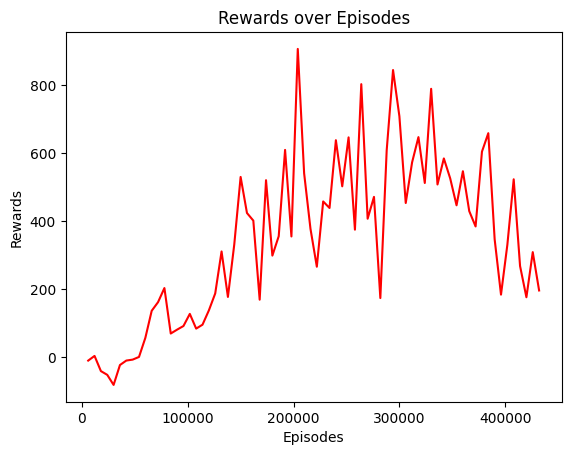

In [ ]:
# Train model
real_vec_env_3, real_env_1 = make_real_env_uber_global()
ckpt_path = "expert"
total_steps = 72_000 * 6
expert_callback = PPOCallback(save_path=ckpt_path, eval_env=real_env_1, eval_fn=evaluate_policy)

# We have 6 parallel envs and 1000 steps per env, which means that we update our
# policy every 6000 timesteps. If we evaluate every
model = PPO(policy="MlpPolicy", env=real_vec_env_3, verbose=3, n_steps=1000)
model.learn(total_timesteps=total_steps, callback=expert_callback)

### (Evaluating expert)

In [ ]:
real_vec_env_3, real_env_1 = make_real_env_uber_global()
expert = PPOActor(ckpt="expert", environment=real_vec_env_3)
result = evaluate_policy(actor=expert, env=real_env_1, num_episodes=10, debug=True)
print(f"\n{result}")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


Avg reward: 692.3333333332318
Avg reward per agent, per game:  {'paddle_0': 69.23333333332319, 'paddle_1': 69.23333333332319}
Full rewards:  {'paddle_0': 692.3333333332318, 'paddle_1': 692.3333333332318}

692.3333333332318


### (Visualizing expert)

In [ ]:
visualize(real_env_1, actor=expert, init_seed=3)
Video("test.mp4", embed=True)

Video saved as test.mp4


# Part 2: Half Observation

### HalfObservationPongEnv


In [ ]:
class HalfObservationPongEnv(BaseWrapper):
    """
    Cooperative pong where each agent observes only their half of the environment.
    """
    def __init__(self, env: AECEnv):
        BaseWrapper.__init__(self, env)
        self.env = env

    def last(self):
      obs, reward, termination, truncation, info = self.env.last()

      internal = self.env.unwrapped.env
      width = 480

      left_paddle_pos = internal.p0.rect.midleft
      right_paddle_pos = internal.p1.rect.midright
      ball_pos = internal.ball.rect.center
      ball_speed = internal.ball.speed

      if self.env.agent_selection == "paddle_0":
          if ball_pos[0] <= width / 2:
              state = np.array([
                  [left_paddle_pos[0], left_paddle_pos[1]],
                  [ball_pos[0], ball_pos[1]],
                  [ball_speed[0], ball_speed[1]]
              ])
          else:
              state = np.array([
                  [left_paddle_pos[0], left_paddle_pos[1]],
                  [0, 0],
                  [0, 0]
              ])
      elif self.env.agent_selection == "paddle_1":
          if ball_pos[0] > width / 2:
              state = np.array([
                  [right_paddle_pos[0], right_paddle_pos[1]],
                  [ball_pos[0], ball_pos[1]],
                  [ball_speed[0], ball_speed[1]]
              ])
          else:
              state = np.array([
                  [right_paddle_pos[0], right_paddle_pos[1]],
                  [0, 0],
                  [0, 0]
              ])

      return state, reward, termination, truncation, info


class ParallelHalfObservationPongEnv(BaseParallelWrapper):
    """
    Cooperative pong where each agent observes only their half of the environment.

    The observation for parallel envs is a dict of:
        {
            agent1: np.ndarray,
            agent2: np.ndarray
        }
    """
    def __init__(self, env: ParallelEnv):
        BaseParallelWrapper.__init__(self, env)
        self.env = env

        # Update observation space for each agent
        for agent in ["paddle_0", "paddle_1"]:
            original_space = self.env.unwrapped.observation_spaces[agent]

            # New shape only contains agent-specific half observations
            new_shape = ([3, 2])
            new_space = Box(
                low=0,
                high=255,
                shape=new_shape,
                dtype=np.int64
            )

            self.env.unwrapped.observation_spaces[agent] = new_space

    def full_state(self):
        # Find internal env and construct vectorized state
        internal = self.env.unwrapped.env
        width = 480

        left_paddle_pos = internal.p0.rect.midleft
        right_paddle_pos = internal.p1.rect.midright
        ball_pos = internal.ball.rect.center
        ball_speed = internal.ball.speed

        state = {}

        if ball_pos[0] <= width / 2:
            state["paddle_0"] = np.array([
                [left_paddle_pos[0], left_paddle_pos[1]],
                [ball_pos[0], ball_pos[1]],
                [ball_speed[0], ball_speed[1]]
            ])
        else:
            state["paddle_0"] = np.array([
                [left_paddle_pos[0], left_paddle_pos[1]],
                [0, 0],
                [0, 0]
            ])
        if ball_pos[0] > width / 2:
            state["paddle_1"] = np.array([
                [right_paddle_pos[0], right_paddle_pos[1]],
                [ball_pos[0], ball_pos[1]],
                [ball_speed[0], ball_speed[1]]
            ])
        else:
            state["paddle_1"] = np.array([
                [right_paddle_pos[0], right_paddle_pos[1]],
                [0, 0],
                [0, 0]
            ])

        return state

    def reset(self, seed=None, options=None):
        obs, infos = self.env.reset(seed, options)

        state = self.full_state()

        # Create new obs for each agent
        new_obs = {}
        for agent in self.env.agents:
            new_obs[agent] = state[agent]

        return new_obs, infos

    def step(self, actions):
        obs, reward, termination, truncation, info = self.env.step(actions)

        state = self.full_state()

        # Create new obs for each agent
        new_obs = {}
        for agent in self.env.agents:
            new_obs[agent] = state[agent]

        return new_obs, reward, termination, truncation, info

### make_real_env_half

In [ ]:
def make_real_env_half(init_seed=seed) -> tuple[VecEnv, AECEnv]:
    """
    Just like `make_real_env` except that the environments now return half-observations
    for each agent, rather than the full state space.
    """
    # Create parallel env for training
    parallel_env = cooperative_pong_v5.parallel_env(render_mode="rgb_array")
    parallel_env = ParallelHalfObservationPongEnv(parallel_env)
    parallel_env.reset(seed=init_seed)

    real_vec_env_3 = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
    real_vec_env_3 = ss.concat_vec_envs_v1(real_vec_env_3, num_vec_envs=3, num_cpus=1, base_class="stable_baselines3")

    # Create AEC env for evaluation
    env = cooperative_pong_v5.env(render_mode="rgb_array")
    env = HalfObservationPongEnv(env)

    return real_vec_env_3, env

### evaluate_policy_half

In [ ]:
def evaluate_policy_half(env: AECEnv, actor: PPOActor=None, num_episodes=100, progress=True, debug=False):
    """
    Returns the mean trajectory reward of rolling out `actor` on `environment

    Args:
        actor: PPOActor instance
        environment: AECEnv instance
        num_episodes: total number of trajectories to collect and average over
    """
    rewards = {agent: 0 for agent in env.possible_agents}
    iterate = (trange(num_episodes) if progress else range(num_episodes))

    for i in iterate:
        env.reset(seed=i)

        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()

            for a in env.agents:
                rewards[a] += env.rewards[a]

            if termination or truncation:
                break
            else:
                action = actor.select_action(obs) if actor else env.action_space(agent).sample()

            env.step(action)

    avg_reward = sum(rewards.values()) / len(rewards.values())
    avg_reward_per_agent = {
        agent: rewards[agent] / num_episodes for agent in env.possible_agents
    }

    if debug:
        print(f"\nAvg reward: {avg_reward}")
        print("Avg reward per agent, per game: ", avg_reward_per_agent)
        print("Full rewards: ", rewards)

    return avg_reward

### (Train Half Agents)

Using cuda device
----------------------------
| time/              |     |
|    fps             | 286 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 600 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 260          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 1200         |
| train/                  |              |
|    approx_kl            | 0.0122575415 |
|    clip_fraction        | 0.104        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.0655       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.815        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0135      |
|    value_loss           | 8.44         |
------------------------------------------
-----

100%|██████████| 20/20 [00:11<00:00,  1.76it/s]

evaluating self.num_timesteps=6000, mean_reward=-54.22222222222223=======
model saved on eval reward: -54.22222222222223
-----------------------------------------
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 10          |
|    time_elapsed         | 39          |
|    total_timesteps      | 6000        |
| train/                  |             |
|    approx_kl            | 0.014253637 |
|    clip_fraction        | 0.0673      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.477       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.67        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 3.15        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 158          |
|    iterations           | 11           |
|    time_elapsed         | 41           |
|    total_timesteps      | 6600         |
| train/                  |              |
|    approx_kl            | 0.0033586782 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.437        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.52         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00295     |
|    value_loss           | 3.77         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 12          |
|    time_elapsed         | 44          |
|    total_times

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

evaluating self.num_timesteps=12000, mean_reward=-8.333333333333425=======
model saved on eval reward: -8.333333333333425
------------------------------------------
| time/                   |              |
|    fps                  | 150          |
|    iterations           | 20           |
|    time_elapsed         | 79           |
|    total_timesteps      | 12000        |
| train/                  |              |
|    approx_kl            | 0.0054805293 |
|    clip_fraction        | 0.0132       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.994       |
|    explained_variance   | 0.412        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.519        |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00638     |
|    value_loss           | 2.95         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 153          |
|    iterations           | 21           |
|    time_elapsed         | 82           |
|    total_timesteps      | 12600        |
| train/                  |              |
|    approx_kl            | 0.0061415127 |
|    clip_fraction        | 0.0489       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1           |
|    explained_variance   | 0.33         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.381        |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.01        |
|    value_loss           | 2.18         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 22          |
|    time_elapsed         | 84          |
|    total_times

100%|██████████| 20/20 [00:10<00:00,  1.96it/s]

evaluating self.num_timesteps=18000, mean_reward=-42.66666666666636=======
-----------------------------------------
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 30          |
|    time_elapsed         | 118         |
|    total_timesteps      | 18000       |
| train/                  |             |
|    approx_kl            | 0.012331886 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.942      |
|    explained_variance   | 0.0102      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.111       |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 1.68        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 31          |
|    time_elapsed         | 120         |
|    total_timesteps      | 18600       |
| train/                  |             |
|    approx_kl            | 0.004503647 |
|    clip_fraction        | 0.0278      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.905      |
|    explained_variance   | 0.612       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.315       |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.00542    |
|    value_loss           | 2.02        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 32          |
|    time_elapsed         | 123         |
|    total_timesteps      | 19200 

100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

evaluating self.num_timesteps=24000, mean_reward=51.55555555555928=======
model saved on eval reward: 51.55555555555928
-----------------------------------------
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 40          |
|    time_elapsed         | 161         |
|    total_timesteps      | 24000       |
| train/                  |             |
|    approx_kl            | 0.004701282 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.924      |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.23        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00991    |
|    value_loss           | 5.59        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 41          |
|    time_elapsed         | 164         |
|    total_timesteps      | 24600       |
| train/                  |             |
|    approx_kl            | 0.008707934 |
|    clip_fraction        | 0.0522      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.952      |
|    explained_variance   | 0.319       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.94        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00835    |
|    value_loss           | 5.56        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 151          |
|    iterations           | 42           |
|    time_elapsed         | 166          |
|    total_timesteps      | 2

100%|██████████| 20/20 [00:18<00:00,  1.11it/s]

evaluating self.num_timesteps=30000, mean_reward=112.55555555556069=======
model saved on eval reward: 112.55555555556069
-----------------------------------------
| time/                   |             |
|    fps                  | 144         |
|    iterations           | 50          |
|    time_elapsed         | 207         |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.004100564 |
|    clip_fraction        | 0.0193      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.995      |
|    explained_variance   | 0.463       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.63        |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.00802    |
|    value_loss           | 6.59        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 51          |
|    time_elapsed         | 209         |
|    total_timesteps      | 30600       |
| train/                  |             |
|    approx_kl            | 0.013087325 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.985      |
|    explained_variance   | -0.267      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.144       |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 1.21        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 145         |
|    iterations           | 52          |
|    time_elapsed         | 213         |
|    total_timesteps      | 31200 

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

evaluating self.num_timesteps=36000, mean_reward=288.1111111111015=======
model saved on eval reward: 288.1111111111015
-----------------------------------------
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 60          |
|    time_elapsed         | 265         |
|    total_timesteps      | 36000       |
| train/                  |             |
|    approx_kl            | 0.008147644 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.922      |
|    explained_variance   | 0.464       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.431       |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 6.4         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 61          |
|    time_elapsed         | 268         |
|    total_timesteps      | 36600       |
| train/                  |             |
|    approx_kl            | 0.009708633 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.931      |
|    explained_variance   | 0.587       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.8         |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.00994    |
|    value_loss           | 9.38        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 62          |
|    time_elapsed         | 270         |
|    total_timesteps      | 37200 

100%|██████████| 20/20 [00:29<00:00,  1.45s/it]

evaluating self.num_timesteps=42000, mean_reward=322.9999999999734=======
model saved on eval reward: 322.9999999999734
-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 70          |
|    time_elapsed         | 322         |
|    total_timesteps      | 42000       |
| train/                  |             |
|    approx_kl            | 0.014991799 |
|    clip_fraction        | 0.0952      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.805      |
|    explained_variance   | 0.308       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.113       |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 0.284       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 131         |
|    iterations           | 71          |
|    time_elapsed         | 324         |
|    total_timesteps      | 42600       |
| train/                  |             |
|    approx_kl            | 0.009454663 |
|    clip_fraction        | 0.0538      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.82       |
|    explained_variance   | 0.0952      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0299      |
|    n_updates            | 700         |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 0.202       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 72          |
|    time_elapsed         | 327         |
|    total_timesteps      | 43200 

100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

evaluating self.num_timesteps=48000, mean_reward=264.1111111110993=======
------------------------------------------
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 80           |
|    time_elapsed         | 377          |
|    total_timesteps      | 48000        |
| train/                  |              |
|    approx_kl            | 0.0035840292 |
|    clip_fraction        | 0.00401      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.907       |
|    explained_variance   | 0.532        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.52         |
|    n_updates            | 790          |
|    policy_gradient_loss | -0.00375     |
|    value_loss           | 7.94         |
------------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 81           |
|    time_elapsed         | 380          |
|    total_timesteps      | 48600        |
| train/                  |              |
|    approx_kl            | 0.0057505574 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.901       |
|    explained_variance   | 0.52         |
|    learning_rate        | 0.0003       |
|    loss                 | 3.08         |
|    n_updates            | 800          |
|    policy_gradient_loss | -0.0078      |
|    value_loss           | 5.86         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 82          |
|    time_elapsed         | 382         |
|    total_times

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]

evaluating self.num_timesteps=54000, mean_reward=179.77777777778607=======
------------------------------------------
| time/                   |              |
|    fps                  | 125          |
|    iterations           | 90           |
|    time_elapsed         | 428          |
|    total_timesteps      | 54000        |
| train/                  |              |
|    approx_kl            | 0.0018975415 |
|    clip_fraction        | 0.00339      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.84        |
|    explained_variance   | 0.454        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.31         |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.00457     |
|    value_loss           | 6.85         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 91          |
|    time_elapsed         | 432         |
|    total_timesteps      | 54600       |
| train/                  |             |
|    approx_kl            | 0.004079153 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.872      |
|    explained_variance   | 0.651       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.704       |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.00769    |
|    value_loss           | 4.93        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 92           |
|    time_elapsed         | 434          |
|    total_timesteps      | 5

100%|██████████| 20/20 [00:09<00:00,  2.19it/s]

evaluating self.num_timesteps=60000, mean_reward=-47.66666666666513=======
-----------------------------------------
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 100         |
|    time_elapsed         | 466         |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.008686144 |
|    clip_fraction        | 0.0693      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.956      |
|    explained_variance   | 0.0228      |
|    learning_rate        | 0.0003      |
|    loss                 | 2.75        |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 3.66        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 129          |
|    iterations           | 101          |
|    time_elapsed         | 469          |
|    total_timesteps      | 60600        |
| train/                  |              |
|    approx_kl            | 0.0043614064 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.858       |
|    explained_variance   | 0.364        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.94         |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00677     |
|    value_loss           | 6.65         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 129         |
|    iterations           | 102         |
|    time_elapsed         | 473         |
|    total_times

100%|██████████| 20/20 [00:12<00:00,  1.55it/s]

evaluating self.num_timesteps=66000, mean_reward=11.777777777778926=======
-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 110         |
|    time_elapsed         | 507         |
|    total_timesteps      | 66000       |
| train/                  |             |
|    approx_kl            | 0.009483511 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.839      |
|    explained_variance   | 0.292       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.17        |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 5.4         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 111         |
|    time_elapsed         | 511         |
|    total_timesteps      | 66600       |
| train/                  |             |
|    approx_kl            | 0.023672247 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.89       |
|    explained_variance   | 0.401       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.11        |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 3.68        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 112         |
|    time_elapsed         | 513         |
|    total_timesteps      | 67200 

100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

evaluating self.num_timesteps=72000, mean_reward=338.11111111108625=======
model saved on eval reward: 338.11111111108625
------------------------------------------
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 120          |
|    time_elapsed         | 565          |
|    total_timesteps      | 72000        |
| train/                  |              |
|    approx_kl            | 0.0052672056 |
|    clip_fraction        | 0.0296       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.823       |
|    explained_variance   | 0.688        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.846        |
|    n_updates            | 1190         |
|    policy_gradient_loss | -0.00565     |
|    value_loss           | 3.23         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 121         |
|    time_elapsed         | 568         |
|    total_timesteps      | 72600       |
| train/                  |             |
|    approx_kl            | 0.009656261 |
|    clip_fraction        | 0.0573      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.859      |
|    explained_variance   | 0.514       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.75        |
|    n_updates            | 1200        |
|    policy_gradient_loss | -0.00793    |
|    value_loss           | 6.57        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 122          |
|    time_elapsed         | 570          |
|    total_timesteps      | 7

100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

evaluating self.num_timesteps=78000, mean_reward=227.44444444445412=======
-----------------------------------------
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 130         |
|    time_elapsed         | 618         |
|    total_timesteps      | 78000       |
| train/                  |             |
|    approx_kl            | 0.003163465 |
|    clip_fraction        | 0.0283      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.815      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.59        |
|    n_updates            | 1290        |
|    policy_gradient_loss | -0.00641    |
|    value_loss           | 10.6        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 131          |
|    time_elapsed         | 620          |
|    total_timesteps      | 78600        |
| train/                  |              |
|    approx_kl            | 0.0046843276 |
|    clip_fraction        | 0.0271       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.806       |
|    explained_variance   | 0.584        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.84         |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.00643     |
|    value_loss           | 9.04         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 127          |
|    iterations           | 132          |
|    time_elapsed         | 623          |
|    total_

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]

evaluating self.num_timesteps=84000, mean_reward=326.6666666666417=======
-----------------------------------------
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 140         |
|    time_elapsed         | 674         |
|    total_timesteps      | 84000       |
| train/                  |             |
|    approx_kl            | 0.024270132 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.87       |
|    explained_variance   | -0.471      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0938      |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.0181     |
|    value_loss           | 0.27        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 141         |
|    time_elapsed         | 677         |
|    total_timesteps      | 84600       |
| train/                  |             |
|    approx_kl            | 0.005100622 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.794      |
|    explained_variance   | 0.0847      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.943       |
|    n_updates            | 1400        |
|    policy_gradient_loss | -0.00515    |
|    value_loss           | 4.73        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 125          |
|    iterations           | 142          |
|    time_elapsed         | 679          |
|    total_timesteps      | 8

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

evaluating self.num_timesteps=90000, mean_reward=280.7777777777576=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 150         |
|    time_elapsed         | 728         |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.011762073 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.87       |
|    explained_variance   | -0.934      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0849      |
|    n_updates            | 1490        |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 0.263       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 151         |
|    time_elapsed         | 731         |
|    total_timesteps      | 90600       |
| train/                  |             |
|    approx_kl            | 0.010939093 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.872      |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.86        |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 4.66        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 152          |
|    time_elapsed         | 733          |
|    total_timesteps      | 9

100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

evaluating self.num_timesteps=96000, mean_reward=145.0000000000076=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 160         |
|    time_elapsed         | 776         |
|    total_timesteps      | 96000       |
| train/                  |             |
|    approx_kl            | 0.009135337 |
|    clip_fraction        | 0.0558      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.862      |
|    explained_variance   | 0.662       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.98        |
|    n_updates            | 1590        |
|    policy_gradient_loss | -0.00852    |
|    value_loss           | 3.97        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 161          |
|    time_elapsed         | 780          |
|    total_timesteps      | 96600        |
| train/                  |              |
|    approx_kl            | 0.0125481915 |
|    clip_fraction        | 0.103        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.89        |
|    explained_variance   | 0.721        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.477        |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0165      |
|    value_loss           | 3.23         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 162         |
|    time_elapsed         | 782         |
|    total_times

100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

evaluating self.num_timesteps=102000, mean_reward=182.44444444445256=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 170         |
|    time_elapsed         | 826         |
|    total_timesteps      | 102000      |
| train/                  |             |
|    approx_kl            | 0.009702127 |
|    clip_fraction        | 0.0799      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.808      |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.2         |
|    n_updates            | 1690        |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 6.34        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 171          |
|    time_elapsed         | 828          |
|    total_timesteps      | 102600       |
| train/                  |              |
|    approx_kl            | 0.0115874335 |
|    clip_fraction        | 0.0979       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.853       |
|    explained_variance   | 0.342        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.42         |
|    n_updates            | 1700         |
|    policy_gradient_loss | -0.0138      |
|    value_loss           | 6.56         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 172         |
|    time_elapsed         | 831         |
|    total_times

100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

evaluating self.num_timesteps=108000, mean_reward=187.00000000000907=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 180         |
|    time_elapsed         | 876         |
|    total_timesteps      | 108000      |
| train/                  |             |
|    approx_kl            | 0.008314788 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.819      |
|    explained_variance   | 0.475       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.3         |
|    n_updates            | 1790        |
|    policy_gradient_loss | -0.0151     |
|    value_loss           | 5.88        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 181          |
|    time_elapsed         | 879          |
|    total_timesteps      | 108600       |
| train/                  |              |
|    approx_kl            | 0.0053680693 |
|    clip_fraction        | 0.0439       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.756       |
|    explained_variance   | 0.431        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.97         |
|    n_updates            | 1800         |
|    policy_gradient_loss | -0.00651     |
|    value_loss           | 7.69         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 182         |
|    time_elapsed         | 881         |
|    total_times

100%|██████████| 20/20 [00:20<00:00,  1.02s/it]

evaluating self.num_timesteps=114000, mean_reward=155.22222222223024=======
----------------------------------------
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 190        |
|    time_elapsed         | 924        |
|    total_timesteps      | 114000     |
| train/                  |            |
|    approx_kl            | 0.00915605 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.774     |
|    explained_variance   | 0.00719    |
|    learning_rate        | 0.0003     |
|    loss                 | 3.97       |
|    n_updates            | 1890       |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 9.68       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 191         |
|    time_elapsed         | 928         |
|    total_timesteps      | 114600      |
| train/                  |             |
|    approx_kl            | 0.007404648 |
|    clip_fraction        | 0.0573      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.77       |
|    explained_variance   | 0.154       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.79        |
|    n_updates            | 1900        |
|    policy_gradient_loss | -0.00859    |
|    value_loss           | 5.67        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 192         |
|    time_elapsed         | 930         |
|    total_timesteps      | 115200

100%|██████████| 20/20 [00:15<00:00,  1.25it/s]

evaluating self.num_timesteps=120000, mean_reward=57.222222222227614=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 200         |
|    time_elapsed         | 970         |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.009083392 |
|    clip_fraction        | 0.062       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.79       |
|    explained_variance   | 0.586       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.761       |
|    n_updates            | 1990        |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 6.13        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 201         |
|    time_elapsed         | 973         |
|    total_timesteps      | 120600      |
| train/                  |             |
|    approx_kl            | 0.016056862 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.791      |
|    explained_variance   | -0.285      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.951       |
|    n_updates            | 2000        |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 5.14        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 202         |
|    time_elapsed         | 975         |
|    total_timesteps      | 121200

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

evaluating self.num_timesteps=126000, mean_reward=243.88888888889488=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 210         |
|    time_elapsed         | 1023        |
|    total_timesteps      | 126000      |
| train/                  |             |
|    approx_kl            | 0.010209002 |
|    clip_fraction        | 0.0937      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.781      |
|    explained_variance   | 0.42        |
|    learning_rate        | 0.0003      |
|    loss                 | 4.14        |
|    n_updates            | 2090        |
|    policy_gradient_loss | -0.00813    |
|    value_loss           | 5.24        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 211         |
|    time_elapsed         | 1026        |
|    total_timesteps      | 126600      |
| train/                  |             |
|    approx_kl            | 0.026785161 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.769      |
|    explained_variance   | 0.231       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0591      |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.029      |
|    value_loss           | 0.635       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 212         |
|    time_elapsed         | 1028        |
|    total_timesteps      | 127200

100%|██████████| 20/20 [00:21<00:00,  1.06s/it]

evaluating self.num_timesteps=132000, mean_reward=181.7777777777846=======
----------------------------------------
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 220        |
|    time_elapsed         | 1072       |
|    total_timesteps      | 132000     |
| train/                  |            |
|    approx_kl            | 0.01414079 |
|    clip_fraction        | 0.0747     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.887     |
|    explained_variance   | 0.387      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.613      |
|    n_updates            | 2190       |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 3.43       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 221         |
|    time_elapsed         | 1076        |
|    total_timesteps      | 132600      |
| train/                  |             |
|    approx_kl            | 0.007310229 |
|    clip_fraction        | 0.0676      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.886      |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.51        |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 10.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 222         |
|    time_elapsed         | 1078        |
|    total_timesteps      | 133200

100%|██████████| 20/20 [00:21<00:00,  1.07s/it]

evaluating self.num_timesteps=138000, mean_reward=155.33333333334213=======
---------------------------------------
| time/                   |           |
|    fps                  | 123       |
|    iterations           | 230       |
|    time_elapsed         | 1121      |
|    total_timesteps      | 138000    |
| train/                  |           |
|    approx_kl            | 0.0188574 |
|    clip_fraction        | 0.137     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.922    |
|    explained_variance   | 0.485     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.0277    |
|    n_updates            | 2290      |
|    policy_gradient_loss | -0.0213   |
|    value_loss           | 0.385     |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 231         |
|    time_elapsed         | 1123        |
|    total_timesteps      | 138600      |
| train/                  |             |
|    approx_kl            | 0.010328819 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.902      |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.74        |
|    n_updates            | 2300        |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 7.19        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 232          |
|    time_elapsed         | 1126         |
|    total_timesteps      | 1

100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

evaluating self.num_timesteps=144000, mean_reward=276.2222222222165=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 240         |
|    time_elapsed         | 1177        |
|    total_timesteps      | 144000      |
| train/                  |             |
|    approx_kl            | 0.015735079 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.923      |
|    explained_variance   | 0.0633      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.55        |
|    n_updates            | 2390        |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 7.43        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 241         |
|    time_elapsed         | 1179        |
|    total_timesteps      | 144600      |
| train/                  |             |
|    approx_kl            | 0.011270996 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.889      |
|    explained_variance   | -0.0536     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.869       |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 3.45        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 242        |
|    time_elapsed         | 1182       |
|    total_timesteps      | 145200     

100%|██████████| 20/20 [00:16<00:00,  1.18it/s]

evaluating self.num_timesteps=150000, mean_reward=97.44444444444913=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 250         |
|    time_elapsed         | 1221        |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.007294291 |
|    clip_fraction        | 0.0565      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.831      |
|    explained_variance   | 0.111       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23        |
|    n_updates            | 2490        |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 4.16        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 251         |
|    time_elapsed         | 1225        |
|    total_timesteps      | 150600      |
| train/                  |             |
|    approx_kl            | 0.012502673 |
|    clip_fraction        | 0.0994      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.889      |
|    explained_variance   | 0.364       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.49        |
|    n_updates            | 2500        |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 4.75        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 252         |
|    time_elapsed         | 1228        |
|    total_timesteps      | 151200

100%|██████████| 20/20 [00:21<00:00,  1.09s/it]

evaluating self.num_timesteps=156000, mean_reward=177.44444444445108=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 260         |
|    time_elapsed         | 1271        |
|    total_timesteps      | 156000      |
| train/                  |             |
|    approx_kl            | 0.010890844 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.859      |
|    explained_variance   | 0.33        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 2590        |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 4.25        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 261         |
|    time_elapsed         | 1273        |
|    total_timesteps      | 156600      |
| train/                  |             |
|    approx_kl            | 0.011359901 |
|    clip_fraction        | 0.0843      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.868      |
|    explained_variance   | 0.552       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.864       |
|    n_updates            | 2600        |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 3.53        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 262         |
|    time_elapsed         | 1276        |
|    total_timesteps      | 157200

100%|██████████| 20/20 [00:12<00:00,  1.58it/s]

evaluating self.num_timesteps=162000, mean_reward=-20.55555555555344=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 270         |
|    time_elapsed         | 1310        |
|    total_timesteps      | 162000      |
| train/                  |             |
|    approx_kl            | 0.030035976 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.849      |
|    explained_variance   | 0.351       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0353      |
|    n_updates            | 2690        |
|    policy_gradient_loss | -0.0258     |
|    value_loss           | 0.178       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 271         |
|    time_elapsed         | 1313        |
|    total_timesteps      | 162600      |
| train/                  |             |
|    approx_kl            | 0.007298595 |
|    clip_fraction        | 0.0884      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.816      |
|    explained_variance   | 0.282       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.87        |
|    n_updates            | 2700        |
|    policy_gradient_loss | -0.00937    |
|    value_loss           | 5.82        |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 124       |
|    iterations           | 272       |
|    time_elapsed         | 1315      |
|    total_timesteps      | 163200    |
| tr

100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

evaluating self.num_timesteps=168000, mean_reward=210.77777777778542=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 280         |
|    time_elapsed         | 1361        |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.020217879 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.908      |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.367       |
|    n_updates            | 2790        |
|    policy_gradient_loss | -0.0254     |
|    value_loss           | 2.36        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 281         |
|    time_elapsed         | 1363        |
|    total_timesteps      | 168600      |
| train/                  |             |
|    approx_kl            | 0.011739289 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.849      |
|    explained_variance   | 0.218       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.53        |
|    n_updates            | 2800        |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 8.43        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 282          |
|    time_elapsed         | 1366         |
|    total_timesteps      | 1

100%|██████████| 20/20 [00:20<00:00,  1.03s/it]

evaluating self.num_timesteps=174000, mean_reward=172.444444444451=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 290         |
|    time_elapsed         | 1409        |
|    total_timesteps      | 174000      |
| train/                  |             |
|    approx_kl            | 0.010740614 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.796      |
|    explained_variance   | 0.492       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.6         |
|    n_updates            | 2890        |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 7.49        |
-----------------------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 123          |
|    iterations           | 291          |
|    time_elapsed         | 1413         |
|    total_timesteps      | 174600       |
| train/                  |              |
|    approx_kl            | 0.0134187415 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.778       |
|    explained_variance   | 0.686        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.132        |
|    n_updates            | 2900         |
|    policy_gradient_loss | -0.014       |
|    value_loss           | 0.568        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 292         |
|    time_elapsed         | 1416        |
|    total_times

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

evaluating self.num_timesteps=180000, mean_reward=235.77777777778581=======
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 300         |
|    time_elapsed         | 1462        |
|    total_timesteps      | 180000      |
| train/                  |             |
|    approx_kl            | 0.018298356 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.769      |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0775      |
|    n_updates            | 2990        |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 0.322       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 301         |
|    time_elapsed         | 1466        |
|    total_timesteps      | 180600      |
| train/                  |             |
|    approx_kl            | 0.008874061 |
|    clip_fraction        | 0.0483      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.748      |
|    explained_variance   | 0.299       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.914       |
|    n_updates            | 3000        |
|    policy_gradient_loss | -0.00351    |
|    value_loss           | 5.48        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 302         |
|    time_elapsed         | 1469        |
|    total_timesteps      | 181200

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

evaluating self.num_timesteps=186000, mean_reward=189.22222222222956=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 310         |
|    time_elapsed         | 1515        |
|    total_timesteps      | 186000      |
| train/                  |             |
|    approx_kl            | 0.008012278 |
|    clip_fraction        | 0.0441      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.738      |
|    explained_variance   | 0.371       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.808       |
|    n_updates            | 3090        |
|    policy_gradient_loss | -0.00965    |
|    value_loss           | 6.55        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 311         |
|    time_elapsed         | 1518        |
|    total_timesteps      | 186600      |
| train/                  |             |
|    approx_kl            | 0.008493239 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.797      |
|    explained_variance   | 0.568       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.63        |
|    n_updates            | 3100        |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 6.58        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 312         |
|    time_elapsed         | 1521        |
|    total_timesteps      | 187200

100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

evaluating self.num_timesteps=192000, mean_reward=185.55555555556273=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 320         |
|    time_elapsed         | 1565        |
|    total_timesteps      | 192000      |
| train/                  |             |
|    approx_kl            | 0.009818367 |
|    clip_fraction        | 0.0648      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.833      |
|    explained_variance   | 0.659       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.155       |
|    n_updates            | 3190        |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 2.95        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 321         |
|    time_elapsed         | 1568        |
|    total_timesteps      | 192600      |
| train/                  |             |
|    approx_kl            | 0.010122007 |
|    clip_fraction        | 0.0917      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.822      |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.48        |
|    n_updates            | 3200        |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 3.74        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 322         |
|    time_elapsed         | 1570        |
|    total_timesteps      | 193200

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

evaluating self.num_timesteps=198000, mean_reward=160.6666666666753=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 330         |
|    time_elapsed         | 1615        |
|    total_timesteps      | 198000      |
| train/                  |             |
|    approx_kl            | 0.015748456 |
|    clip_fraction        | 0.0852      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.838      |
|    explained_variance   | 0.45        |
|    learning_rate        | 0.0003      |
|    loss                 | 3.06        |
|    n_updates            | 3290        |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 9.59        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 331         |
|    time_elapsed         | 1618        |
|    total_timesteps      | 198600      |
| train/                  |             |
|    approx_kl            | 0.009136405 |
|    clip_fraction        | 0.0513      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.848      |
|    explained_variance   | 0.0885      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.17        |
|    n_updates            | 3300        |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 5.8         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 332         |
|    time_elapsed         | 1620        |
|    total_timesteps      | 199200

100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

evaluating self.num_timesteps=204000, mean_reward=219.33333333334122=======
----------------------------------------
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 340        |
|    time_elapsed         | 1669       |
|    total_timesteps      | 204000     |
| train/                  |            |
|    approx_kl            | 0.01322888 |
|    clip_fraction        | 0.0731     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.793     |
|    explained_variance   | 0.272      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.49       |
|    n_updates            | 3390       |
|    policy_gradient_loss | -0.0097    |
|    value_loss           | 5.79       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 341         |
|    time_elapsed         | 1671        |
|    total_timesteps      | 204600      |
| train/                  |             |
|    approx_kl            | 0.019809816 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.807      |
|    explained_variance   | 0.254       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.147       |
|    n_updates            | 3400        |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 0.83        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 342         |
|    time_elapsed         | 1674        |
|    total_timesteps      | 205200

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]

evaluating self.num_timesteps=210000, mean_reward=201.0000000000089=======
------------------------------------------
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 350          |
|    time_elapsed         | 1718         |
|    total_timesteps      | 210000       |
| train/                  |              |
|    approx_kl            | 0.0072965114 |
|    clip_fraction        | 0.0615       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.792       |
|    explained_variance   | 0.486        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.64         |
|    n_updates            | 3490         |
|    policy_gradient_loss | -0.0119      |
|    value_loss           | 11.1         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 351         |
|    time_elapsed         | 1723        |
|    total_timesteps      | 210600      |
| train/                  |             |
|    approx_kl            | 0.008720143 |
|    clip_fraction        | 0.0423      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.751      |
|    explained_variance   | 0.0247      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.518       |
|    n_updates            | 3500        |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 3.96        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 352         |
|    time_elapsed         | 1725        |
|    total_timesteps      | 211200

100%|██████████| 20/20 [00:27<00:00,  1.35s/it]

evaluating self.num_timesteps=216000, mean_reward=240.6666666666751=======
----------------------------------------
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 360        |
|    time_elapsed         | 1773       |
|    total_timesteps      | 216000     |
| train/                  |            |
|    approx_kl            | 0.01494235 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.776     |
|    explained_variance   | 0.1        |
|    learning_rate        | 0.0003     |
|    loss                 | 3.35       |
|    n_updates            | 3590       |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 3.78       |
----------------------------------------


model saved on eval reward: 338.11111111108625


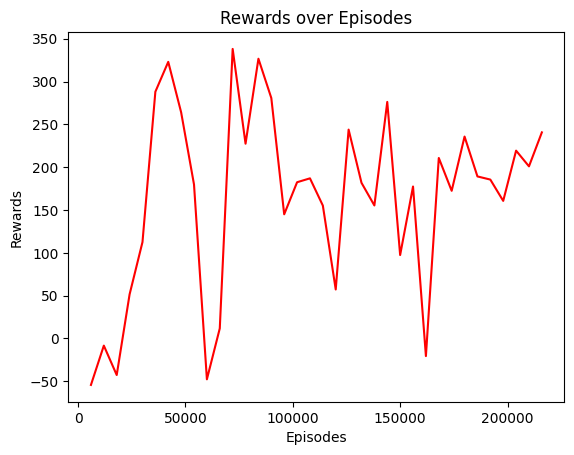

In [ ]:
half_vec_env_3, half_env_1 = make_real_env_half()
ckpt_path = "halfagent"
total_steps = 72_000*3
halfagent_callback = PPOCallback(save_path=ckpt_path, eval_env=half_env_1, eval_fn=evaluate_policy_half)

model = PPO(policy="MlpPolicy", env=half_vec_env_3, verbose=3, n_steps=100)
model.learn(total_timesteps=total_steps, callback=halfagent_callback)

### (Evaluate Half Agents)

In [ ]:
half_vec_env_3, half_env_1 = make_real_env_half()
halfagent = PPOActor(ckpt="halfagent", environment=half_vec_env_3)
result = evaluate_policy_half(actor=halfagent, env=half_env_1, num_episodes=10, debug=True)
print(f"\n{result}")

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Avg reward: 263.11111111111455
Avg reward per agent, per game:  {'paddle_0': 26.311111111111455, 'paddle_1': 26.311111111111455}
Full rewards:  {'paddle_0': 263.11111111111455, 'paddle_1': 263.11111111111455}

263.11111111111455


### (Visualize Half Agents)

In [ ]:
visualize(half_env_1, actor=halfagent, init_seed=3)
Video("test.mp4", embed=True)

Video saved as test.mp4


## ModifiedPosition

### ModifiedPongEnv

In [ ]:

class ModifiedCooperativePongEnv(BaseWrapper):
    """
    Cooperative pong where the observation space returns the full state space
    instead of the default observation space
    """
    def __init__(self, env: AECEnv):
        BaseWrapper.__init__(self, env)
        self.env = env

    def last(self):
        obs, reward, termination, truncation, info = self.env.last()

        # Find internal env and construct vectorized state
        internal = self.env.unwrapped.env

        # Extract positions
        left_paddle_pos = internal.p0.rect.midleft
        right_paddle_pos = internal.p1.rect.midright
        ball_pos = internal.ball.rect.center
        ball_speed = internal.ball.speed

        # Compute relative positions
        relative_ball_pos_left = (ball_pos[0] - internal.p0.rect.centerx, ball_pos[1] - internal.p0.rect.centery)
        relative_ball_pos_right = (ball_pos[0] - internal.p1.rect.centerx, ball_pos[1] - internal.p1.rect.centery)

        # Create limited state for each agent
        if self.env.agent_selection == "paddle_0":
          state = np.array([
            [left_paddle_pos[0], left_paddle_pos[1]],
            [relative_ball_pos_left[0], relative_ball_pos_left[1]],
            [ball_speed[0], ball_speed[1]]
          ])
        else:  # For "paddle_1"
          state = np.array([
            [right_paddle_pos[0], right_paddle_pos[1]],
            [relative_ball_pos_right[0], relative_ball_pos_right[1]],
            [ball_speed[0], ball_speed[1]]
          ])

        return state, reward, termination, truncation, info


class ParallelModifiedCooperativePongEnv(BaseParallelWrapper):
    """
    Cooperative pong where the observation space returns the full state space
    instead of the default observation space

    The observation for parallel envs is a dict of:
        {
            agent1: np.ndarray,
            agent2: np.ndarray
        }
    """
    def __init__(self, env: ParallelEnv):
        BaseParallelWrapper.__init__(self, env)
        self.env = env

        # Update observation space
        for agent in ["paddle_0", "paddle_1"]:
            original_space = self.env.unwrapped.observation_spaces[agent]

            new_shape = ([3, 2])
            new_space = Box(
                low=0,
                high=255,
                shape=new_shape,
                dtype=np.int64
            )

            # print(original_space)
            # print(new_space)

            self.env.unwrapped.observation_spaces[agent] = new_space


    def full_state(self):
      # Find internal env and construct vectorized state
        internal = self.env.unwrapped.env

        # Extract positions
        left_paddle_pos = internal.p0.rect.midleft
        right_paddle_pos = internal.p1.rect.midright
        ball_pos = internal.ball.rect.center
        ball_speed = internal.ball.speed

        # Compute relative positions
        relative_ball_pos_left = (ball_pos[0] - internal.p0.rect.centerx, ball_pos[1] - internal.p0.rect.centery)
        relative_ball_pos_right = (ball_pos[0] - internal.p1.rect.centerx, ball_pos[1] - internal.p1.rect.centery)

        # Create limited state for each agent
        state = {
            "paddle_0": np.array([
            [left_paddle_pos[0], left_paddle_pos[1]],
            [relative_ball_pos_left[0], relative_ball_pos_left[1]],
            [ball_speed[0], ball_speed[1]]
          ]),
            "paddle_1": np.array([
            [right_paddle_pos[0], right_paddle_pos[1]],
            [relative_ball_pos_right[0], relative_ball_pos_right[1]],
            [ball_speed[0], ball_speed[1]]
          ])
        }
        return state

    def reset(self, seed=None, options=None):
        obs, infos = self.env.reset(seed, options)

        state = self.full_state()

        # Create new obs
        new_obs = {}
        for agent in self.env.agents:
            new_obs[agent] = state[agent]

        return new_obs, infos


    def step(self, actions):
        obs, reward, termination, truncation, info = self.env.step(actions)

        state = self.full_state()

        # Create new obs
        new_obs = {}
        for agent in self.env.agents:
            new_obs[agent] = state[agent]


        return new_obs, reward, termination, truncation, info

### make_real_env_modified_global

In [ ]:
def make_real_env_modified_global(init_seed=seed) -> tuple[VecEnv, AECEnv]:
    """
    Just like `make_real_env` except that the environments now return the full
    state space for each observation, rather than the limited observation space
    """
    # Create parallel env for training
    parallel_env = cooperative_pong_v5.parallel_env(render_mode="rgb_array")
    parallel_env = ParallelModifiedCooperativePongEnv(parallel_env)
    parallel_env.reset(seed=init_seed)

    real_vec_env_3 = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
    real_vec_env_3 = ss.concat_vec_envs_v1(real_vec_env_3, num_vec_envs=3, num_cpus=1, base_class="stable_baselines3")

    # Create AEC env for evaluation
    env = cooperative_pong_v5.env(render_mode="rgb_array")
    env = ModifiedCooperativePongEnv(env)

    return real_vec_env_3, env

### PPOCallback

In [ ]:
class PPOCallback(BaseCallback):
    def __init__(self, verbose=0, save_path='default', eval_env=None):
        super(PPOCallback, self).__init__(verbose)
        self.rewards = []

        self.save_freq = 2000 # save every 2000 timesteps, aka every policy update
        self.min_reward = -np.inf
        self.actor = None
        self.eval_env = eval_env

        self.save_path = save_path

        self.eval_steps = []
        self.eval_rewards = []

    def _init_callback(self) -> None:
        pass

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.actor = PPOActor(model=self.model)

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        episode_info = self.model.ep_info_buffer
        rewards = [ep_info['r'] for ep_info in episode_info]
        mean_rewards = np.mean(rewards)

        self.rewards.append(mean_rewards)

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        if self.eval_env is None:
            return True

        if self.num_timesteps % self.save_freq == 0 and self.num_timesteps != 0:
            mean_reward = evaluate_policy(actor=self.actor, env=self.eval_env, num_episodes=20)
            print(f'evaluating {self.num_timesteps=}, {mean_reward=}=======')

            self.eval_steps.append(self.num_timesteps)
            self.eval_rewards.append(mean_reward)
            if mean_reward > self.min_reward:
                self.min_reward = mean_reward
                self.model.save(self.save_path)
                print(f'model saved on eval reward: {self.min_reward}')

        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        print(f'model saved on eval reward: {self.min_reward}')

        plt.plot(self.eval_steps, self.eval_rewards, c='red')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('Rewards over Episodes')

        plt.show()
        plt.close()

### (Train Modified Agents)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 6000`, after every 93 untruncated mini-batches, there will be a truncated mini-batch of size 48
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1000 and n_envs=6)
  warnings.warn(


Using cpu device


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]

evaluating self.num_timesteps=6000, mean_reward=-73.33333333333229=======
model saved on eval reward: -73.33333333333229
-----------------------------
| time/              |      |
|    fps             | 173  |
|    iterations      | 1    |
|    time_elapsed    | 34   |
|    total_timesteps | 6000 |
-----------------------------



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

evaluating self.num_timesteps=12000, mean_reward=-50.55555555555425=======
model saved on eval reward: -50.55555555555425
----------------------------------------
| time/                   |            |
|    fps                  | 157        |
|    iterations           | 2          |
|    time_elapsed         | 76         |
|    total_timesteps      | 12000      |
| train/                  |            |
|    approx_kl            | 0.00811315 |
|    clip_fraction        | 0.0339     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | -0.00418   |
|    learning_rate        | 0.0003     |
|    loss                 | 3.42       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00491   |
|    value_loss           | 7.52       |
----------------------------------------



100%|██████████| 20/20 [00:08<00:00,  2.33it/s]

evaluating self.num_timesteps=18000, mean_reward=-92.22222222221987=======
-----------------------------------------
| time/                   |             |
|    fps                  | 156         |
|    iterations           | 3           |
|    time_elapsed         | 114         |
|    total_timesteps      | 18000       |
| train/                  |             |
|    approx_kl            | 0.007592484 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.424       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.86        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00814    |
|    value_loss           | 5.1         |
-----------------------------------------



100%|██████████| 20/20 [00:10<00:00,  1.96it/s]

evaluating self.num_timesteps=24000, mean_reward=-51.22222222222239=======
------------------------------------------
| time/                   |              |
|    fps                  | 155          |
|    iterations           | 4            |
|    time_elapsed         | 154          |
|    total_timesteps      | 24000        |
| train/                  |              |
|    approx_kl            | 0.0075384923 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.471        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.93         |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00779     |
|    value_loss           | 4.13         |
------------------------------------------



100%|██████████| 20/20 [00:09<00:00,  2.20it/s]

evaluating self.num_timesteps=30000, mean_reward=-56.333333333333385=======
-----------------------------------------
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 5           |
|    time_elapsed         | 193         |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.007920869 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.4         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00869    |
|    value_loss           | 3.46        |
-----------------------------------------



100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

evaluating self.num_timesteps=36000, mean_reward=12.99999999999973=======
model saved on eval reward: 12.99999999999973
-----------------------------------------
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 6           |
|    time_elapsed         | 238         |
|    total_timesteps      | 36000       |
| train/                  |             |
|    approx_kl            | 0.009086036 |
|    clip_fraction        | 0.0823      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.571       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.95        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 4.52        |
-----------------------------------------



100%|██████████| 20/20 [00:18<00:00,  1.06it/s]

evaluating self.num_timesteps=42000, mean_reward=93.8888888888929=======
model saved on eval reward: 93.8888888888929
------------------------------------------
| time/                   |              |
|    fps                  | 146          |
|    iterations           | 7            |
|    time_elapsed         | 286          |
|    total_timesteps      | 42000        |
| train/                  |              |
|    approx_kl            | 0.0087101115 |
|    clip_fraction        | 0.0855       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.03        |
|    explained_variance   | 0.544        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.95         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00909     |
|    value_loss           | 4.27         |
------------------------------------------



100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

evaluating self.num_timesteps=48000, mean_reward=172.0000000000064=======
model saved on eval reward: 172.0000000000064
-----------------------------------------
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 8           |
|    time_elapsed         | 342         |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.009573681 |
|    clip_fraction        | 0.0913      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.545       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.32        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00819    |
|    value_loss           | 3.68        |
-----------------------------------------



100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

evaluating self.num_timesteps=54000, mean_reward=151.55555555556285=======
------------------------------------------
| time/                   |              |
|    fps                  | 136          |
|    iterations           | 9            |
|    time_elapsed         | 395          |
|    total_timesteps      | 54000        |
| train/                  |              |
|    approx_kl            | 0.0071462644 |
|    clip_fraction        | 0.0717       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.994       |
|    explained_variance   | 0.569        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.71         |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00708     |
|    value_loss           | 5.02         |
------------------------------------------



100%|██████████| 20/20 [00:34<00:00,  1.71s/it]

evaluating self.num_timesteps=60000, mean_reward=338.55555555554685=======
model saved on eval reward: 338.55555555554685
-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 10          |
|    time_elapsed         | 458         |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.007914569 |
|    clip_fraction        | 0.0847      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.974      |
|    explained_variance   | 0.507       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00644    |
|    value_loss           | 4.74        |
-----------------------------------------



100%|██████████| 20/20 [00:35<00:00,  1.77s/it]

evaluating self.num_timesteps=66000, mean_reward=380.2222222222007=======
model saved on eval reward: 380.2222222222007
-----------------------------------------
| time/                   |             |
|    fps                  | 126         |
|    iterations           | 11          |
|    time_elapsed         | 523         |
|    total_timesteps      | 66000       |
| train/                  |             |
|    approx_kl            | 0.010246628 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.954      |
|    explained_variance   | 0.573       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.4         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00758    |
|    value_loss           | 3.26        |
-----------------------------------------



100%|██████████| 20/20 [00:32<00:00,  1.64s/it]

evaluating self.num_timesteps=72000, mean_reward=304.5555555555545=======
-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 12          |
|    time_elapsed         | 586         |
|    total_timesteps      | 72000       |
| train/                  |             |
|    approx_kl            | 0.009331236 |
|    clip_fraction        | 0.0992      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.951      |
|    explained_variance   | 0.373       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.71        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0083     |
|    value_loss           | 4.05        |
-----------------------------------------



100%|██████████| 20/20 [00:48<00:00,  2.44s/it]

evaluating self.num_timesteps=78000, mean_reward=462.77777777771865=======
model saved on eval reward: 462.77777777771865
----------------------------------------
| time/                   |            |
|    fps                  | 117        |
|    iterations           | 13         |
|    time_elapsed         | 665        |
|    total_timesteps      | 78000      |
| train/                  |            |
|    approx_kl            | 0.00925498 |
|    clip_fraction        | 0.0989     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.939     |
|    explained_variance   | 0.592      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.69       |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.00527   |
|    value_loss           | 2.5        |
----------------------------------------



100%|██████████| 20/20 [01:10<00:00,  3.52s/it]

evaluating self.num_timesteps=84000, mean_reward=967.5555555553987=======
model saved on eval reward: 967.5555555553987
-----------------------------------------
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 14          |
|    time_elapsed         | 768         |
|    total_timesteps      | 84000       |
| train/                  |             |
|    approx_kl            | 0.008477732 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.924      |
|    explained_variance   | 0.588       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.644       |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.004      |
|    value_loss           | 2.99        |
-----------------------------------------



100%|██████████| 20/20 [01:22<00:00,  4.13s/it]

evaluating self.num_timesteps=90000, mean_reward=1184.3333333331136=======
model saved on eval reward: 1184.3333333331136
-----------------------------------------
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 15          |
|    time_elapsed         | 882         |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.010936376 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.896      |
|    explained_variance   | 0.31        |
|    learning_rate        | 0.0003      |
|    loss                 | 1.38        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0061     |
|    value_loss           | 1.41        |
-----------------------------------------



100%|██████████| 20/20 [01:38<00:00,  4.92s/it]

evaluating self.num_timesteps=96000, mean_reward=1479.222222221937=======
model saved on eval reward: 1479.222222221937
-----------------------------------------
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 16          |
|    time_elapsed         | 1010        |
|    total_timesteps      | 96000       |
| train/                  |             |
|    approx_kl            | 0.018417848 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.935      |
|    explained_variance   | -0.0516     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.321       |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00381    |
|    value_loss           | 1.58        |
-----------------------------------------



100%|██████████| 20/20 [01:46<00:00,  5.33s/it]

evaluating self.num_timesteps=102000, mean_reward=1606.5555555552412=======
model saved on eval reward: 1606.5555555552412
-----------------------------------------
| time/                   |             |
|    fps                  | 88          |
|    iterations           | 17          |
|    time_elapsed         | 1146        |
|    total_timesteps      | 102000      |
| train/                  |             |
|    approx_kl            | 0.012839813 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.857      |
|    explained_variance   | 0.0468      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.248       |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00373    |
|    value_loss           | 0.608       |
-----------------------------------------



100%|██████████| 20/20 [01:55<00:00,  5.78s/it]

evaluating self.num_timesteps=108000, mean_reward=1807.1111111107602=======
model saved on eval reward: 1807.1111111107602
------------------------------------------
| time/                   |              |
|    fps                  | 83           |
|    iterations           | 18           |
|    time_elapsed         | 1291         |
|    total_timesteps      | 108000       |
| train/                  |              |
|    approx_kl            | 0.0135407485 |
|    clip_fraction        | 0.161        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.897       |
|    explained_variance   | 0.0508       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.259        |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00561     |
|    value_loss           | 2.87         |
------------------------------------------



100%|██████████| 20/20 [01:52<00:00,  5.65s/it]

evaluating self.num_timesteps=114000, mean_reward=1722.111111110775=======
----------------------------------------
| time/                   |            |
|    fps                  | 79         |
|    iterations           | 19         |
|    time_elapsed         | 1433       |
|    total_timesteps      | 114000     |
| train/                  |            |
|    approx_kl            | 0.01616188 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.897     |
|    explained_variance   | -0.0143    |
|    learning_rate        | 0.0003     |
|    loss                 | 0.149      |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.00219   |
|    value_loss           | 1.28       |
----------------------------------------



100%|██████████| 20/20 [01:46<00:00,  5.31s/it]

evaluating self.num_timesteps=120000, mean_reward=1652.3333333330156=======
-----------------------------------------
| time/                   |             |
|    fps                  | 76          |
|    iterations           | 20          |
|    time_elapsed         | 1569        |
|    total_timesteps      | 120000      |
| train/                  |             |
|    approx_kl            | 0.012552061 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.871      |
|    explained_variance   | -0.095      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.553       |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00311    |
|    value_loss           | 1.35        |
-----------------------------------------



100%|██████████| 20/20 [01:34<00:00,  4.73s/it]

evaluating self.num_timesteps=126000, mean_reward=1426.4444444441688=======
-----------------------------------------
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 21          |
|    time_elapsed         | 1694        |
|    total_timesteps      | 126000      |
| train/                  |             |
|    approx_kl            | 0.013893921 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.883      |
|    explained_variance   | -0.0537     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0784      |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00189    |
|    value_loss           | 1.67        |
-----------------------------------------



100%|██████████| 20/20 [01:53<00:00,  5.65s/it]

evaluating self.num_timesteps=132000, mean_reward=1751.6666666663261=======
-----------------------------------------
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 22          |
|    time_elapsed         | 1836        |
|    total_timesteps      | 132000      |
| train/                  |             |
|    approx_kl            | 0.010277684 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.893      |
|    explained_variance   | -0.0624     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0516      |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.005      |
|    value_loss           | 1.46        |
-----------------------------------------



100%|██████████| 20/20 [01:35<00:00,  4.78s/it]

evaluating self.num_timesteps=138000, mean_reward=1422.4444444441629=======
-----------------------------------------
| time/                   |             |
|    fps                  | 70          |
|    iterations           | 23          |
|    time_elapsed         | 1962        |
|    total_timesteps      | 138000      |
| train/                  |             |
|    approx_kl            | 0.018320335 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.858      |
|    explained_variance   | 0.0551      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0477      |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00228    |
|    value_loss           | 1.41        |
-----------------------------------------



100%|██████████| 20/20 [01:44<00:00,  5.25s/it]

evaluating self.num_timesteps=144000, mean_reward=1598.6666666663543=======
------------------------------------------
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 24           |
|    time_elapsed         | 2097         |
|    total_timesteps      | 144000       |
| train/                  |              |
|    approx_kl            | 0.0078164255 |
|    clip_fraction        | 0.0841       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.863       |
|    explained_variance   | 0.132        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.364        |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00282     |
|    value_loss           | 3.14         |
------------------------------------------



100%|██████████| 20/20 [01:42<00:00,  5.14s/it]

evaluating self.num_timesteps=150000, mean_reward=1604.444444444133=======
-----------------------------------------
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 25          |
|    time_elapsed         | 2230        |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.016883943 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.881      |
|    explained_variance   | -0.0429     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.17        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00409    |
|    value_loss           | 2.98        |
-----------------------------------------



100%|██████████| 20/20 [01:43<00:00,  5.16s/it]

evaluating self.num_timesteps=156000, mean_reward=1615.666666666358=======
-----------------------------------------
| time/                   |             |
|    fps                  | 66          |
|    iterations           | 26          |
|    time_elapsed         | 2363        |
|    total_timesteps      | 156000      |
| train/                  |             |
|    approx_kl            | 0.018280607 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.826      |
|    explained_variance   | -0.0995     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0329      |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00227    |
|    value_loss           | 1.05        |
-----------------------------------------



100%|██████████| 20/20 [01:43<00:00,  5.18s/it]

evaluating self.num_timesteps=162000, mean_reward=1636.9999999996835=======
-----------------------------------------
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 27          |
|    time_elapsed         | 2498        |
|    total_timesteps      | 162000      |
| train/                  |             |
|    approx_kl            | 0.016125642 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.827      |
|    explained_variance   | 0.0234      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0312      |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00198    |
|    value_loss           | 1.14        |
-----------------------------------------



100%|██████████| 20/20 [01:46<00:00,  5.34s/it]

evaluating self.num_timesteps=168000, mean_reward=1716.888888888554=======
-----------------------------------------
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 28          |
|    time_elapsed         | 2634        |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.017990192 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.834      |
|    explained_variance   | -0.243      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.206       |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.00133    |
|    value_loss           | 0.71        |
-----------------------------------------



100%|██████████| 20/20 [01:56<00:00,  5.84s/it]

evaluating self.num_timesteps=174000, mean_reward=1826.3333333329783=======
model saved on eval reward: 1826.3333333329783
-----------------------------------------
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 29          |
|    time_elapsed         | 2781        |
|    total_timesteps      | 174000      |
| train/                  |             |
|    approx_kl            | 0.010651102 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.793      |
|    explained_variance   | -0.0446     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.244       |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00158    |
|    value_loss           | 1.66        |
-----------------------------------------



100%|██████████| 20/20 [02:04<00:00,  6.23s/it]

evaluating self.num_timesteps=180000, mean_reward=1981.7777777773895=======
model saved on eval reward: 1981.7777777773895
-----------------------------------------
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 30          |
|    time_elapsed         | 2936        |
|    total_timesteps      | 180000      |
| train/                  |             |
|    approx_kl            | 0.014195172 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.773      |
|    explained_variance   | -0.00592    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.275       |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00102    |
|    value_loss           | 1.44        |
-----------------------------------------



100%|██████████| 20/20 [01:46<00:00,  5.34s/it]

evaluating self.num_timesteps=186000, mean_reward=1671.888888888562=======
-----------------------------------------
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 31          |
|    time_elapsed         | 3072        |
|    total_timesteps      | 186000      |
| train/                  |             |
|    approx_kl            | 0.012981545 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.791      |
|    explained_variance   | -0.037      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0551      |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.00534    |
|    value_loss           | 0.928       |
-----------------------------------------



100%|██████████| 20/20 [02:01<00:00,  6.05s/it]

evaluating self.num_timesteps=192000, mean_reward=1914.333333332958=======
-----------------------------------------
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 32          |
|    time_elapsed         | 3222        |
|    total_timesteps      | 192000      |
| train/                  |             |
|    approx_kl            | 0.015845828 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.855      |
|    explained_variance   | -0.0464     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.233       |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0036     |
|    value_loss           | 1.69        |
-----------------------------------------



100%|██████████| 20/20 [01:46<00:00,  5.32s/it]

evaluating self.num_timesteps=198000, mean_reward=1662.1111111107818=======
-----------------------------------------
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 33          |
|    time_elapsed         | 3357        |
|    total_timesteps      | 198000      |
| train/                  |             |
|    approx_kl            | 0.014136503 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.835      |
|    explained_variance   | -0.0501     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.252       |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00315    |
|    value_loss           | 0.764       |
-----------------------------------------



100%|██████████| 20/20 [01:47<00:00,  5.38s/it]

evaluating self.num_timesteps=204000, mean_reward=1633.9999999996771=======
------------------------------------------
| time/                   |              |
|    fps                  | 58           |
|    iterations           | 34           |
|    time_elapsed         | 3494         |
|    total_timesteps      | 204000       |
| train/                  |              |
|    approx_kl            | 0.0151225785 |
|    clip_fraction        | 0.175        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.832       |
|    explained_variance   | 0.0173       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.266        |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00684     |
|    value_loss           | 0.759        |
------------------------------------------



100%|██████████| 20/20 [01:46<00:00,  5.31s/it]

evaluating self.num_timesteps=210000, mean_reward=1647.5555555552296=======
-----------------------------------------
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 35          |
|    time_elapsed         | 3629        |
|    total_timesteps      | 210000      |
| train/                  |             |
|    approx_kl            | 0.012096998 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.85       |
|    explained_variance   | 0.0121      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.812       |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00372    |
|    value_loss           | 1.84        |
-----------------------------------------



100%|██████████| 20/20 [01:27<00:00,  4.37s/it]

evaluating self.num_timesteps=216000, mean_reward=1235.9999999997565=======
-----------------------------------------
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 36          |
|    time_elapsed         | 3746        |
|    total_timesteps      | 216000      |
| train/                  |             |
|    approx_kl            | 0.008360808 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.876      |
|    explained_variance   | 0.00554     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.936       |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00394    |
|    value_loss           | 1.84        |
-----------------------------------------


model saved on eval reward: 1981.7777777773895


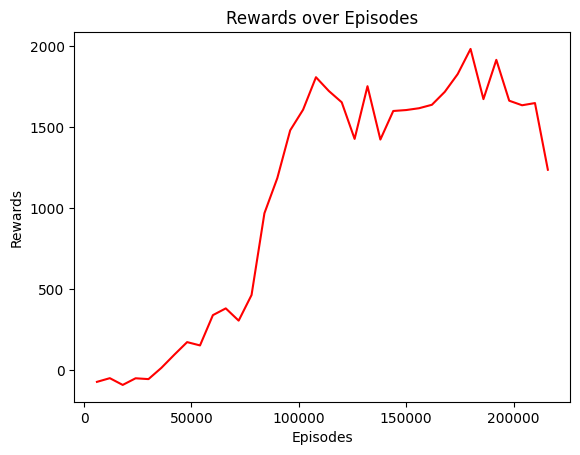

In [ ]:
# Train model
real_vec_env_3, real_env_1 = make_real_env_modified_global()
ckpt_path = "limited"
total_steps = 72_000*3
limited_callback = PPOCallback(save_path=ckpt_path, eval_env=real_env_1)

# We have 6 parallel envs and 1000 steps per env, which means that we update our
# policy every 6000 timesteps. If we evaluate every
model = PPO(policy="MlpPolicy", env=real_vec_env_3, verbose=3, n_steps=1000)
model.learn(total_timesteps=total_steps, callback=limited_callback)

### (Evaluate Modified Agents)

In [ ]:
env_3, env_1 = make_real_env_modified_global()
limited = PPOActor(ckpt="limited", environment=env_3)
result = evaluate_policy(actor=limited, env=env_1, num_episodes=10, debug=True)
print(f"\n{result}")

100%|██████████| 10/10 [00:57<00:00,  5.78s/it]


Avg reward: 999.9999999998371
Avg reward per agent, per game:  {'paddle_0': 99.99999999998371, 'paddle_1': 99.99999999998371}
Full rewards:  {'paddle_0': 999.9999999998371, 'paddle_1': 999.9999999998371}

999.9999999998371


### (Visualize Modified Agents)

In [ ]:
visualize(env_1, actor=limited, init_seed=3)
# visualize(real_env_1, init_seed=0)
Video("test.mp4", embed=True)

Video saved as test.mp4


# Part 3: DAgger Learner

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import trange
import random
import torch.nn.functional as F

In [ ]:
class DAggerPongLearner(nn.Module):
    def __init__(self, obs_dim, action_dim, expert, env, lr=1e-3, iterations=30, batch_size=64):
        """
        DAgger learner as NN

        Args:
            obs_dim: observation space is 4x2 and flattened to 8
            action_dim: action space is 3 for 3 possible movement directions
            expert: trained expert
        """
        super(DAggerPongLearner, self).__init__()
        self.env = env
        self.expert = expert
        self.iterations = iterations
        self.batch_size = batch_size

        self.policy = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()

        self.cur_dataset = []

    def forward(self, x):
        return self.policy(x)

    def collect_data(self):
        """Collect data by rolling out current policy and querying expert"""

        self.env.reset()
        obs, *_ = self.env.last()
        done = False

        while not done:
            obs_tensor = torch.tensor(obs.flatten(), dtype=torch.float32)

            # choose action
            with torch.no_grad():
                action_probs = self(obs_tensor)
                action = torch.argmax(action_probs).item()

            # query expert
            expert_action = self.expert.select_action(obs)

            # append to dataset
            self.cur_dataset.append((obs, expert_action))

            # step env
            self.env.step(action)
            obs, _, termination, truncation, _ = self.env.last()
            done = termination or truncation


    def train_policy(self):
        """Train over current dataset"""

        # set up dataloader
        states, actions = zip(*self.cur_dataset)
        states = [state.flatten() for state in states]
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.long)
        dataset = TensorDataset(states, actions)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # train learner
        self.train()
        for epoch in range(20):
            for batch_states, batch_actions in dataloader:
                self.optimizer.zero_grad()
                outputs = self(batch_states)
                loss = self.criterion(outputs, batch_actions)
                loss.backward()
                self.optimizer.step()

    def learn(self):
      """Train DAgger learner"""
      val_iter = 10

      for i in range(self.iterations):
        print(f"Iteration {i + 1}/{self.iterations}")
        self.collect_data()
        self.train_policy()

        if (i+1)%val_iter==0:
          self.evaluate()

    def evaluate(self, val_eps=10):
      """
      Evaluate policy over new episodes.
      """
      total_reward = 0

      self.eval()
      for episode in range(val_eps):
          self.env.reset()
          obs, *_ = self.env.last()
          done = False
          episode_reward = 0

          while not done:
              obs_tensor = torch.tensor(obs.flatten(), dtype=torch.float32)

              with torch.no_grad():
                  action_probs = self(obs_tensor)
                  action = torch.argmax(action_probs).item()

              self.env.step(action)
              obs, reward, terminated, truncated, info = self.env.last()
              done = terminated or truncated

              episode_reward += reward

          print(f"Episode Reward: {episode_reward}")
          total_reward += episode_reward

      average_reward = total_reward / val_eps
      print(f"Average Reward: {average_reward}")


In [ ]:
daggeragent = DAggerPongLearner(8,3,expert,real_env_1)
daggeragent.learn()

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 76.66666666666812
Episode Reward: 45.3333333333339
Episode Reward: 199.88888888889355
Episode Reward: 29.111111111111214
Episode Reward: 199.88888888889355
Average Reward: 155.0333333333368
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Episode Reward: 104.00000000000223
Episode Reward: 199.88888888889355
Episode Reward: 185.5555555555601
Episode Reward: 30.444444444444585
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 24.4444444444

In [ ]:
daggeragent.evaluate()

Episode Reward: -3.5555555555555634
Episode Reward: 199.88888888889355
Episode Reward: 44.222222222222754
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 9.111111111111061
Episode Reward: -3.5555555555555634
Episode Reward: 7.999999999999954
Episode Reward: 42.88888888888938
Episode Reward: 15.333333333333261
Average Reward: 71.2111111111126


In [ ]:
def visualize_dagger(env: AECEnv, actor, video_name="test", init_seed=seed):
    """
    Returns the mean trajectory reward of rolling out `actor` on `environment

    Args:
        actor: dagger agent
        environment: AECEnv instance
        video_name: Name for the mp4 file of the episode that will be saved (omit .mp4)
    """
    env.reset(seed=init_seed)

    # Empty video
    frames = []

    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
        obs_tensor = torch.tensor(obs.flatten(), dtype=torch.float32)

        if termination or truncation:
            break
        else:
            with torch.no_grad():
              action_probs = actor(obs_tensor)
              action = torch.argmax(action_probs).item()

              env.step(action)
              obs, reward, terminated, truncated, info = env.last()
              done = terminated or truncated

        env.step(action)

        # Write to video
        frames.append(env.render())

    imageio.mimsave(f"{video_name}.mp4", frames, fps=20)
    print(f"Video saved as {video_name}.mp4")

In [ ]:
visualize_dagger(real_env_1, daggeragent, init_seed=0)
Video("test.mp4", embed=True)

Video saved as test.mp4


In [ ]:
daggeragent_limited = DAggerPongLearner(6,3,limited,env_1)
daggeragent_limited.learn()

Iteration 1/30
Iteration 2/30
Iteration 3/30
Iteration 4/30
Iteration 5/30
Iteration 6/30
Iteration 7/30
Iteration 8/30
Iteration 9/30
Iteration 10/30
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Average Reward: 199.88888888889352
Iteration 11/30
Iteration 12/30
Iteration 13/30
Iteration 14/30
Iteration 15/30
Iteration 16/30
Iteration 17/30
Iteration 18/30
Iteration 19/30
Iteration 20/30
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.8888

In [ ]:
daggeragent_limited.evaluate()

Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Episode Reward: 199.88888888889355
Average Reward: 199.88888888889352


In [ ]:

visualize_dagger(env_1, daggeragent_limited, init_seed=3)
Video("test.mp4", embed=True)

Video saved as test.mp4
